# Miller age

In [1]:
ood_seed = 1

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip adjacent cells', '15.0'), 282)


Removed datapoint: 282

train         5748
validation    1375
ood            282
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 97973.34it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 668434.76it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 155.59it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<19:48,  2.98s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<19:48,  2.98s/it, v_num=1, recon=1.2e+3, r2_mean=0.0654, adv_loss=3.45, acc_pert=0.337, acc_integration_donor=0.134]

Epoch 2/400:   0%|          | 1/400 [00:02<19:48,  2.98s/it, v_num=1, recon=1.2e+3, r2_mean=0.0654, adv_loss=3.45, acc_pert=0.337, acc_integration_donor=0.134]

Epoch 2/400:   0%|          | 2/400 [00:10<37:16,  5.62s/it, v_num=1, recon=1.2e+3, r2_mean=0.0654, adv_loss=3.45, acc_pert=0.337, acc_integration_donor=0.134]

Epoch 2/400:   0%|          | 2/400 [00:10<37:16,  5.62s/it, v_num=1, recon=1.02e+3, r2_mean=0.286, adv_loss=2.98, acc_pert=0.486, acc_integration_donor=0.354]

Epoch 3/400:   0%|          | 2/400 [00:10<37:16,  5.62s/it, v_num=1, recon=1.02e+3, r2_mean=0.286, adv_loss=2.98, acc_pert=0.486, acc_integration_donor=0.354]

Epoch 3/400:   1%|          | 3/400 [00:15<36:12,  5.47s/it, v_num=1, recon=1.02e+3, r2_mean=0.286, adv_loss=2.98, acc_pert=0.486, acc_integration_donor=0.354]

Epoch 3/400:   1%|          | 3/400 [00:15<36:12,  5.47s/it, v_num=1, recon=942, r2_mean=0.381, adv_loss=2.66, acc_pert=0.51, acc_integration_donor=0.439]     

Epoch 4/400:   1%|          | 3/400 [00:15<36:12,  5.47s/it, v_num=1, recon=942, r2_mean=0.381, adv_loss=2.66, acc_pert=0.51, acc_integration_donor=0.439]

Epoch 4/400:   1%|          | 4/400 [00:18<28:14,  4.28s/it, v_num=1, recon=942, r2_mean=0.381, adv_loss=2.66, acc_pert=0.51, acc_integration_donor=0.439]

Epoch 4/400:   1%|          | 4/400 [00:18<28:14,  4.28s/it, v_num=1, recon=909, r2_mean=0.427, adv_loss=2.47, acc_pert=0.525, acc_integration_donor=0.483]

Epoch 5/400:   1%|          | 4/400 [00:18<28:14,  4.28s/it, v_num=1, recon=909, r2_mean=0.427, adv_loss=2.47, acc_pert=0.525, acc_integration_donor=0.483]

Epoch 5/400:   1%|▏         | 5/400 [00:20<23:49,  3.62s/it, v_num=1, recon=909, r2_mean=0.427, adv_loss=2.47, acc_pert=0.525, acc_integration_donor=0.483]

Epoch 5/400:   1%|▏         | 5/400 [00:20<23:49,  3.62s/it, v_num=1, recon=891, r2_mean=0.452, adv_loss=2.36, acc_pert=0.532, acc_integration_donor=0.509]

Epoch 6/400:   1%|▏         | 5/400 [00:20<23:49,  3.62s/it, v_num=1, recon=891, r2_mean=0.452, adv_loss=2.36, acc_pert=0.532, acc_integration_donor=0.509]

Epoch 6/400:   2%|▏         | 6/400 [00:23<21:09,  3.22s/it, v_num=1, recon=891, r2_mean=0.452, adv_loss=2.36, acc_pert=0.532, acc_integration_donor=0.509]

Epoch 6/400:   2%|▏         | 6/400 [00:23<21:09,  3.22s/it, v_num=1, recon=879, r2_mean=0.462, adv_loss=2.29, acc_pert=0.536, acc_integration_donor=0.527]

Epoch 7/400:   2%|▏         | 6/400 [00:23<21:09,  3.22s/it, v_num=1, recon=879, r2_mean=0.462, adv_loss=2.29, acc_pert=0.536, acc_integration_donor=0.527]

Epoch 7/400:   2%|▏         | 7/400 [00:25<19:32,  2.98s/it, v_num=1, recon=879, r2_mean=0.462, adv_loss=2.29, acc_pert=0.536, acc_integration_donor=0.527]

Epoch 7/400:   2%|▏         | 7/400 [00:25<19:32,  2.98s/it, v_num=1, recon=871, r2_mean=0.468, adv_loss=2.24, acc_pert=0.538, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 7/400 [00:25<19:32,  2.98s/it, v_num=1, recon=871, r2_mean=0.468, adv_loss=2.24, acc_pert=0.538, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 8/400 [00:28<18:22,  2.81s/it, v_num=1, recon=871, r2_mean=0.468, adv_loss=2.24, acc_pert=0.538, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 8/400 [00:28<18:22,  2.81s/it, v_num=1, recon=864, r2_mean=0.479, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.536] 

Epoch 9/400:   2%|▏         | 8/400 [00:28<18:22,  2.81s/it, v_num=1, recon=864, r2_mean=0.479, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.536]

Epoch 9/400:   2%|▏         | 9/400 [00:30<17:35,  2.70s/it, v_num=1, recon=864, r2_mean=0.479, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.536]

Epoch 9/400:   2%|▏         | 9/400 [00:30<17:35,  2.70s/it, v_num=1, recon=859, r2_mean=0.485, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.53]

Epoch 10/400:   2%|▏         | 9/400 [00:30<17:35,  2.70s/it, v_num=1, recon=859, r2_mean=0.485, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.53]


disnt_basal = 0.5327032318264665

disnt_after = 0.9383400415924069

val_r2_mean = 0.4970794137228619

val_r2_var = 0.2044585414908149


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:40<31:19,  4.82s/it, v_num=1, recon=859, r2_mean=0.485, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.53]

Epoch 10/400:   2%|▎         | 10/400 [00:40<31:19,  4.82s/it, v_num=1, recon=854, r2_mean=0.493, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:40<31:19,  4.82s/it, v_num=1, recon=854, r2_mean=0.493, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:42<27:31,  4.24s/it, v_num=1, recon=854, r2_mean=0.493, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:42<27:31,  4.24s/it, v_num=1, recon=849, r2_mean=0.495, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.524, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:43<27:31,  4.24s/it, v_num=1, recon=849, r2_mean=0.495, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.524, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:45<24:24,  3.77s/it, v_num=1, recon=849, r2_mean=0.495, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.524, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:45<24:24,  3.77s/it, v_num=1, recon=844, r2_mean=0.499, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:45<24:24,  3.77s/it, v_num=1, recon=844, r2_mean=0.499, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:48<22:02,  3.42s/it, v_num=1, recon=844, r2_mean=0.499, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:48<22:02,  3.42s/it, v_num=1, recon=841, r2_mean=0.511, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:48<22:02,  3.42s/it, v_num=1, recon=841, r2_mean=0.511, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:50<20:21,  3.16s/it, v_num=1, recon=841, r2_mean=0.511, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:50<20:21,  3.16s/it, v_num=1, recon=838, r2_mean=0.512, adv_loss=2.15, acc_pert=0.567, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:50<20:21,  3.16s/it, v_num=1, recon=838, r2_mean=0.512, adv_loss=2.15, acc_pert=0.567, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:53<19:04,  2.97s/it, v_num=1, recon=838, r2_mean=0.512, adv_loss=2.15, acc_pert=0.567, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:53<19:04,  2.97s/it, v_num=1, recon=835, r2_mean=0.511, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:53<19:04,  2.97s/it, v_num=1, recon=835, r2_mean=0.511, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:55<18:03,  2.82s/it, v_num=1, recon=835, r2_mean=0.511, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:55<18:03,  2.82s/it, v_num=1, recon=832, r2_mean=0.518, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:55<18:03,  2.82s/it, v_num=1, recon=832, r2_mean=0.518, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:58<17:23,  2.73s/it, v_num=1, recon=832, r2_mean=0.518, adv_loss=2.14, acc_pert=0.558, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:58<17:23,  2.73s/it, v_num=1, recon=830, r2_mean=0.521, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:58<17:23,  2.73s/it, v_num=1, recon=830, r2_mean=0.521, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:00<16:53,  2.65s/it, v_num=1, recon=830, r2_mean=0.521, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:00<16:53,  2.65s/it, v_num=1, recon=829, r2_mean=0.523, adv_loss=2.16, acc_pert=0.559, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:00<16:53,  2.65s/it, v_num=1, recon=829, r2_mean=0.523, adv_loss=2.16, acc_pert=0.559, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:03<16:30,  2.60s/it, v_num=1, recon=829, r2_mean=0.523, adv_loss=2.16, acc_pert=0.559, acc_integration_donor=0.532, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:03<16:30,  2.60s/it, v_num=1, recon=826, r2_mean=0.524, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:03<16:30,  2.60s/it, v_num=1, recon=826, r2_mean=0.524, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]


disnt_basal = 0.5211847457918879

disnt_after = 0.8878511942305884

val_r2_mean = 0.505602237853137

val_r2_var = 0.32558912512930954


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:08<22:17,  3.52s/it, v_num=1, recon=826, r2_mean=0.524, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.529, val_recon=856, disnt_basal=0.533, disnt_after=0.938, val_r2_mean=0.497, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:08<22:17,  3.52s/it, v_num=1, recon=824, r2_mean=0.527, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.533, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:08<22:17,  3.52s/it, v_num=1, recon=824, r2_mean=0.527, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.533, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:11<20:15,  3.21s/it, v_num=1, recon=824, r2_mean=0.527, adv_loss=2.13, acc_pert=0.555, acc_integration_donor=0.533, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:11<20:15,  3.21s/it, v_num=1, recon=822, r2_mean=0.531, adv_loss=2.12, acc_pert=0.568, acc_integration_donor=0.534, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:11<20:15,  3.21s/it, v_num=1, recon=822, r2_mean=0.531, adv_loss=2.12, acc_pert=0.568, acc_integration_donor=0.534, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:13<18:50,  2.99s/it, v_num=1, recon=822, r2_mean=0.531, adv_loss=2.12, acc_pert=0.568, acc_integration_donor=0.534, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:13<18:50,  2.99s/it, v_num=1, recon=820, r2_mean=0.527, adv_loss=2.14, acc_pert=0.56, acc_integration_donor=0.527, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:13<18:50,  2.99s/it, v_num=1, recon=820, r2_mean=0.527, adv_loss=2.14, acc_pert=0.56, acc_integration_donor=0.527, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:16<17:50,  2.84s/it, v_num=1, recon=820, r2_mean=0.527, adv_loss=2.14, acc_pert=0.56, acc_integration_donor=0.527, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:16<17:50,  2.84s/it, v_num=1, recon=819, r2_mean=0.531, adv_loss=2.17, acc_pert=0.565, acc_integration_donor=0.524, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:16<17:50,  2.84s/it, v_num=1, recon=819, r2_mean=0.531, adv_loss=2.17, acc_pert=0.565, acc_integration_donor=0.524, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:18<17:02,  2.72s/it, v_num=1, recon=819, r2_mean=0.531, adv_loss=2.17, acc_pert=0.565, acc_integration_donor=0.524, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:18<17:02,  2.72s/it, v_num=1, recon=817, r2_mean=0.536, adv_loss=2.18, acc_pert=0.564, acc_integration_donor=0.513, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:18<17:02,  2.72s/it, v_num=1, recon=817, r2_mean=0.536, adv_loss=2.18, acc_pert=0.564, acc_integration_donor=0.513, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:21<16:33,  2.65s/it, v_num=1, recon=817, r2_mean=0.536, adv_loss=2.18, acc_pert=0.564, acc_integration_donor=0.513, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:21<16:33,  2.65s/it, v_num=1, recon=815, r2_mean=0.537, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.521, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:21<16:33,  2.65s/it, v_num=1, recon=815, r2_mean=0.537, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.521, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:23<16:13,  2.60s/it, v_num=1, recon=815, r2_mean=0.537, adv_loss=2.17, acc_pert=0.555, acc_integration_donor=0.521, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:23<16:13,  2.60s/it, v_num=1, recon=815, r2_mean=0.541, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:23<16:13,  2.60s/it, v_num=1, recon=815, r2_mean=0.541, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:26<15:53,  2.56s/it, v_num=1, recon=815, r2_mean=0.541, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:26<15:53,  2.56s/it, v_num=1, recon=813, r2_mean=0.541, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:26<15:53,  2.56s/it, v_num=1, recon=813, r2_mean=0.541, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:28<15:39,  2.53s/it, v_num=1, recon=813, r2_mean=0.541, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:28<15:39,  2.53s/it, v_num=1, recon=811, r2_mean=0.541, adv_loss=2.18, acc_pert=0.56, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [01:28<15:39,  2.53s/it, v_num=1, recon=811, r2_mean=0.541, adv_loss=2.18, acc_pert=0.56, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:31<15:31,  2.51s/it, v_num=1, recon=811, r2_mean=0.541, adv_loss=2.18, acc_pert=0.56, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:31<15:31,  2.51s/it, v_num=1, recon=810, r2_mean=0.54, adv_loss=2.18, acc_pert=0.551, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:31<15:31,  2.51s/it, v_num=1, recon=810, r2_mean=0.54, adv_loss=2.18, acc_pert=0.551, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.5162626806709611

disnt_after = 0.9163118584548261

val_r2_mean = 0.5016501037911936

val_r2_var = 0.34234885329549963


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:45<36:20,  5.89s/it, v_num=1, recon=810, r2_mean=0.54, adv_loss=2.18, acc_pert=0.551, acc_integration_donor=0.523, val_recon=826, disnt_basal=0.521, disnt_after=0.888, val_r2_mean=0.506, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:45<36:20,  5.89s/it, v_num=1, recon=809, r2_mean=0.545, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.518, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:45<36:20,  5.89s/it, v_num=1, recon=809, r2_mean=0.545, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.518, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:47<30:02,  4.89s/it, v_num=1, recon=809, r2_mean=0.545, adv_loss=2.21, acc_pert=0.546, acc_integration_donor=0.518, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:47<30:02,  4.89s/it, v_num=1, recon=808, r2_mean=0.546, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.521, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [01:47<30:02,  4.89s/it, v_num=1, recon=808, r2_mean=0.546, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.521, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:50<25:37,  4.18s/it, v_num=1, recon=808, r2_mean=0.546, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.521, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:50<25:37,  4.18s/it, v_num=1, recon=807, r2_mean=0.547, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:50<25:37,  4.18s/it, v_num=1, recon=807, r2_mean=0.547, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<28:47,  4.71s/it, v_num=1, recon=807, r2_mean=0.547, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<28:47,  4.71s/it, v_num=1, recon=806, r2_mean=0.546, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.522, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:56<28:47,  4.71s/it, v_num=1, recon=806, r2_mean=0.546, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.522, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:58<24:38,  4.04s/it, v_num=1, recon=806, r2_mean=0.546, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.522, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:58<24:38,  4.04s/it, v_num=1, recon=804, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.516, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:58<24:38,  4.04s/it, v_num=1, recon=804, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.516, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:01<21:47,  3.58s/it, v_num=1, recon=804, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.516, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:01<21:47,  3.58s/it, v_num=1, recon=803, r2_mean=0.548, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:01<21:47,  3.58s/it, v_num=1, recon=803, r2_mean=0.548, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:03<19:46,  3.26s/it, v_num=1, recon=803, r2_mean=0.548, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.52, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:03<19:46,  3.26s/it, v_num=1, recon=802, r2_mean=0.55, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:03<19:46,  3.26s/it, v_num=1, recon=802, r2_mean=0.55, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:06<18:20,  3.03s/it, v_num=1, recon=802, r2_mean=0.55, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:06<18:20,  3.03s/it, v_num=1, recon=801, r2_mean=0.556, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.519, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:06<18:20,  3.03s/it, v_num=1, recon=801, r2_mean=0.556, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.519, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:08<17:16,  2.86s/it, v_num=1, recon=801, r2_mean=0.556, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.519, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:08<17:16,  2.86s/it, v_num=1, recon=800, r2_mean=0.556, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.514, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:08<17:16,  2.86s/it, v_num=1, recon=800, r2_mean=0.556, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.514, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:10<16:31,  2.75s/it, v_num=1, recon=800, r2_mean=0.556, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.514, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:10<16:31,  2.75s/it, v_num=1, recon=799, r2_mean=0.552, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.512, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:10<16:31,  2.75s/it, v_num=1, recon=799, r2_mean=0.552, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.512, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4940712469654596

disnt_after = 0.9009021468100106

val_r2_mean = 0.5156752643260089

val_r2_var = 0.37133569473570044


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:29<44:42,  7.45s/it, v_num=1, recon=799, r2_mean=0.552, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.512, val_recon=818, disnt_basal=0.516, disnt_after=0.916, val_r2_mean=0.502, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:29<44:42,  7.45s/it, v_num=1, recon=798, r2_mean=0.558, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:29<44:42,  7.45s/it, v_num=1, recon=798, r2_mean=0.558, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<35:42,  5.97s/it, v_num=1, recon=798, r2_mean=0.558, adv_loss=2.23, acc_pert=0.533, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<35:42,  5.97s/it, v_num=1, recon=797, r2_mean=0.555, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:31<35:42,  5.97s/it, v_num=1, recon=797, r2_mean=0.555, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:34<29:52,  5.01s/it, v_num=1, recon=797, r2_mean=0.555, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:34<29:52,  5.01s/it, v_num=1, recon=796, r2_mean=0.558, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:34<29:52,  5.01s/it, v_num=1, recon=796, r2_mean=0.558, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<25:18,  4.25s/it, v_num=1, recon=796, r2_mean=0.558, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:37<25:18,  4.25s/it, v_num=1, recon=795, r2_mean=0.557, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:37<25:18,  4.25s/it, v_num=1, recon=795, r2_mean=0.557, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<22:08,  3.73s/it, v_num=1, recon=795, r2_mean=0.557, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<22:08,  3.73s/it, v_num=1, recon=794, r2_mean=0.557, adv_loss=2.27, acc_pert=0.527, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:39<22:08,  3.73s/it, v_num=1, recon=794, r2_mean=0.557, adv_loss=2.27, acc_pert=0.527, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<19:52,  3.36s/it, v_num=1, recon=794, r2_mean=0.557, adv_loss=2.27, acc_pert=0.527, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:42<19:52,  3.36s/it, v_num=1, recon=793, r2_mean=0.56, adv_loss=2.25, acc_pert=0.525, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [02:42<19:52,  3.36s/it, v_num=1, recon=793, r2_mean=0.56, adv_loss=2.25, acc_pert=0.525, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:18,  3.10s/it, v_num=1, recon=793, r2_mean=0.56, adv_loss=2.25, acc_pert=0.525, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:18,  3.10s/it, v_num=1, recon=792, r2_mean=0.559, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:44<18:18,  3.10s/it, v_num=1, recon=792, r2_mean=0.559, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:12,  2.93s/it, v_num=1, recon=792, r2_mean=0.559, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:12,  2.93s/it, v_num=1, recon=791, r2_mean=0.558, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.52, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [02:47<17:12,  2.93s/it, v_num=1, recon=791, r2_mean=0.558, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.52, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:49<16:23,  2.79s/it, v_num=1, recon=791, r2_mean=0.558, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.52, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:49<16:23,  2.79s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:49<16:23,  2.79s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<15:51,  2.71s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<15:51,  2.71s/it, v_num=1, recon=789, r2_mean=0.564, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:52<15:51,  2.71s/it, v_num=1, recon=789, r2_mean=0.564, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.48958797516991465

disnt_after = 0.9205135635038523

val_r2_mean = 0.5047549320892855

val_r2_var = 0.37763655321164563


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:04<31:48,  5.45s/it, v_num=1, recon=789, r2_mean=0.564, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.514, val_recon=813, disnt_basal=0.494, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:04<31:48,  5.45s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [03:04<31:48,  5.45s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:07<27:49,  4.78s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:07<27:49,  4.78s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.515, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:07<27:49,  4.78s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.515, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:09<24:07,  4.16s/it, v_num=1, recon=788, r2_mean=0.561, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.515, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:09<24:07,  4.16s/it, v_num=1, recon=787, r2_mean=0.563, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [03:09<24:07,  4.16s/it, v_num=1, recon=787, r2_mean=0.563, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:12<21:11,  3.66s/it, v_num=1, recon=787, r2_mean=0.563, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:12<21:11,  3.66s/it, v_num=1, recon=786, r2_mean=0.568, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:12<21:11,  3.66s/it, v_num=1, recon=786, r2_mean=0.568, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:14<19:05,  3.31s/it, v_num=1, recon=786, r2_mean=0.568, adv_loss=2.26, acc_pert=0.521, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:14<19:05,  3.31s/it, v_num=1, recon=785, r2_mean=0.564, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:14<19:05,  3.31s/it, v_num=1, recon=785, r2_mean=0.564, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:17<18:18,  3.18s/it, v_num=1, recon=785, r2_mean=0.564, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:17<18:18,  3.18s/it, v_num=1, recon=784, r2_mean=0.569, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:17<18:18,  3.18s/it, v_num=1, recon=784, r2_mean=0.569, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:20<17:04,  2.98s/it, v_num=1, recon=784, r2_mean=0.569, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:20<17:04,  2.98s/it, v_num=1, recon=783, r2_mean=0.566, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:20<17:04,  2.98s/it, v_num=1, recon=783, r2_mean=0.566, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:22<16:11,  2.83s/it, v_num=1, recon=783, r2_mean=0.566, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:22<16:11,  2.83s/it, v_num=1, recon=782, r2_mean=0.567, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:22<16:11,  2.83s/it, v_num=1, recon=782, r2_mean=0.567, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:25<15:43,  2.76s/it, v_num=1, recon=782, r2_mean=0.567, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:25<15:43,  2.76s/it, v_num=1, recon=782, r2_mean=0.572, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan] 

Epoch 59/400:  14%|█▍        | 58/400 [03:25<15:43,  2.76s/it, v_num=1, recon=782, r2_mean=0.572, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:27<15:14,  2.68s/it, v_num=1, recon=782, r2_mean=0.572, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:27<15:14,  2.68s/it, v_num=1, recon=781, r2_mean=0.565, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:27<15:14,  2.68s/it, v_num=1, recon=781, r2_mean=0.565, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.4900521194654203

disnt_after = 0.9189210978910335

val_r2_mean = 0.5193427225405519

val_r2_var = 0.383407667956569


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:37<27:42,  4.89s/it, v_num=1, recon=781, r2_mean=0.565, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.49, disnt_after=0.921, val_r2_mean=0.505, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:37<27:42,  4.89s/it, v_num=1, recon=779, r2_mean=0.573, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]   

Epoch 61/400:  15%|█▌        | 60/400 [03:37<27:42,  4.89s/it, v_num=1, recon=779, r2_mean=0.573, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:40<23:46,  4.21s/it, v_num=1, recon=779, r2_mean=0.573, adv_loss=2.3, acc_pert=0.5, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:40<23:46,  4.21s/it, v_num=1, recon=779, r2_mean=0.57, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:40<23:46,  4.21s/it, v_num=1, recon=779, r2_mean=0.57, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:43<20:52,  3.71s/it, v_num=1, recon=779, r2_mean=0.57, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:43<20:52,  3.71s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:43<20:52,  3.71s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:45<18:49,  3.35s/it, v_num=1, recon=778, r2_mean=0.573, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:45<18:49,  3.35s/it, v_num=1, recon=777, r2_mean=0.567, adv_loss=2.29, acc_pert=0.507, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:45<18:49,  3.35s/it, v_num=1, recon=777, r2_mean=0.567, adv_loss=2.29, acc_pert=0.507, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:48<17:25,  3.11s/it, v_num=1, recon=777, r2_mean=0.567, adv_loss=2.29, acc_pert=0.507, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:48<17:25,  3.11s/it, v_num=1, recon=777, r2_mean=0.571, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:48<17:25,  3.11s/it, v_num=1, recon=777, r2_mean=0.571, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:50<16:24,  2.94s/it, v_num=1, recon=777, r2_mean=0.571, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:50<16:24,  2.94s/it, v_num=1, recon=776, r2_mean=0.57, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [03:50<16:24,  2.94s/it, v_num=1, recon=776, r2_mean=0.57, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:53<15:37,  2.81s/it, v_num=1, recon=776, r2_mean=0.57, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:53<15:37,  2.81s/it, v_num=1, recon=776, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.506, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:53<15:37,  2.81s/it, v_num=1, recon=776, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.506, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:55<15:03,  2.71s/it, v_num=1, recon=776, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.506, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:55<15:03,  2.71s/it, v_num=1, recon=774, r2_mean=0.575, adv_loss=2.31, acc_pert=0.494, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:55<15:03,  2.71s/it, v_num=1, recon=774, r2_mean=0.575, adv_loss=2.31, acc_pert=0.494, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:58<14:43,  2.66s/it, v_num=1, recon=774, r2_mean=0.575, adv_loss=2.31, acc_pert=0.494, acc_integration_donor=0.518, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:58<14:43,  2.66s/it, v_num=1, recon=773, r2_mean=0.575, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:58<14:43,  2.66s/it, v_num=1, recon=773, r2_mean=0.575, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:00<14:27,  2.62s/it, v_num=1, recon=773, r2_mean=0.575, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.524, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:00<14:27,  2.62s/it, v_num=1, recon=772, r2_mean=0.577, adv_loss=2.31, acc_pert=0.49, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [04:00<14:27,  2.62s/it, v_num=1, recon=772, r2_mean=0.577, adv_loss=2.31, acc_pert=0.49, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.4929653725277722

disnt_after = 0.9222938059220037

val_r2_mean = 0.5135580098087137

val_r2_var = 0.38010808351365005

Epoch 70/400:  18%|█▊        | 70/400 [04:14<32:54,  5.98s/it, v_num=1, recon=772, r2_mean=0.577, adv_loss=2.31, acc_pert=0.49, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.49, disnt_after=0.919, val_r2_mean=0.519, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:14<32:54,  5.98s/it, v_num=1, recon=771, r2_mean=0.578, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.513, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:14<32:54,  5.98s/it, v_num=1, recon=771, r2_mean=0.578, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.513, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:17<27:43,  5.06s/it, v_num=1, recon=771, r2_mean=0.578, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.513, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:17<27:43,  5.06s/it, v_num=1, recon=770, r2_mean=0.578, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]  

Epoch 72/400:  18%|█▊        | 71/400 [04:17<27:43,  5.06s/it, v_num=1, recon=770, r2_mean=0.578, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:20<23:31,  4.30s/it, v_num=1, recon=770, r2_mean=0.578, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:20<23:31,  4.30s/it, v_num=1, recon=769, r2_mean=0.575, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.511, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:20<23:31,  4.30s/it, v_num=1, recon=769, r2_mean=0.575, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.511, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:22<20:33,  3.77s/it, v_num=1, recon=769, r2_mean=0.575, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.511, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:22<20:33,  3.77s/it, v_num=1, recon=769, r2_mean=0.579, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [04:22<20:33,  3.77s/it, v_num=1, recon=769, r2_mean=0.579, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:25<18:56,  3.49s/it, v_num=1, recon=769, r2_mean=0.579, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:25<18:56,  3.49s/it, v_num=1, recon=768, r2_mean=0.581, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:25<18:56,  3.49s/it, v_num=1, recon=768, r2_mean=0.581, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:28<17:51,  3.30s/it, v_num=1, recon=768, r2_mean=0.581, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:28<17:51,  3.30s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.33, acc_pert=0.49, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]  

Epoch 76/400:  19%|█▉        | 75/400 [04:28<17:51,  3.30s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.33, acc_pert=0.49, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:30<16:48,  3.11s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.33, acc_pert=0.49, acc_integration_donor=0.515, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:30<16:48,  3.11s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:30<16:48,  3.11s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:33<15:41,  2.92s/it, v_num=1, recon=767, r2_mean=0.58, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:33<15:41,  2.92s/it, v_num=1, recon=765, r2_mean=0.58, adv_loss=2.33, acc_pert=0.492, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:33<15:41,  2.92s/it, v_num=1, recon=765, r2_mean=0.58, adv_loss=2.33, acc_pert=0.492, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:35<14:52,  2.77s/it, v_num=1, recon=765, r2_mean=0.58, adv_loss=2.33, acc_pert=0.492, acc_integration_donor=0.512, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:35<14:52,  2.77s/it, v_num=1, recon=765, r2_mean=0.582, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.516, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:35<14:52,  2.77s/it, v_num=1, recon=765, r2_mean=0.582, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.516, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:38<14:20,  2.68s/it, v_num=1, recon=765, r2_mean=0.582, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.516, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:38<14:20,  2.68s/it, v_num=1, recon=764, r2_mean=0.583, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]  

Epoch 80/400:  20%|█▉        | 79/400 [04:38<14:20,  2.68s/it, v_num=1, recon=764, r2_mean=0.583, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.4832903773203103

disnt_after = 0.9285608252281847

val_r2_mean = 0.5114020186585265

val_r2_var = 0.3970834964088032


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:47<24:59,  4.68s/it, v_num=1, recon=764, r2_mean=0.583, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.517, val_recon=811, disnt_basal=0.493, disnt_after=0.922, val_r2_mean=0.514, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:47<24:59,  4.68s/it, v_num=1, recon=763, r2_mean=0.584, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.517, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:47<24:59,  4.68s/it, v_num=1, recon=763, r2_mean=0.584, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.517, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:50<21:38,  4.07s/it, v_num=1, recon=763, r2_mean=0.584, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.517, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:50<21:38,  4.07s/it, v_num=1, recon=762, r2_mean=0.581, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:50<21:38,  4.07s/it, v_num=1, recon=762, r2_mean=0.581, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:52<19:16,  3.64s/it, v_num=1, recon=762, r2_mean=0.581, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:52<19:16,  3.64s/it, v_num=1, recon=761, r2_mean=0.583, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.516, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:52<19:16,  3.64s/it, v_num=1, recon=761, r2_mean=0.583, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.516, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:55<17:37,  3.34s/it, v_num=1, recon=761, r2_mean=0.583, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.516, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:55<17:37,  3.34s/it, v_num=1, recon=761, r2_mean=0.585, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.514, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:55<17:37,  3.34s/it, v_num=1, recon=761, r2_mean=0.585, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.514, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:58<16:27,  3.12s/it, v_num=1, recon=761, r2_mean=0.585, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.514, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:58<16:27,  3.12s/it, v_num=1, recon=760, r2_mean=0.586, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:58<16:27,  3.12s/it, v_num=1, recon=760, r2_mean=0.586, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:01<17:11,  3.27s/it, v_num=1, recon=760, r2_mean=0.586, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:01<17:11,  3.27s/it, v_num=1, recon=759, r2_mean=0.583, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [05:01<17:11,  3.27s/it, v_num=1, recon=759, r2_mean=0.583, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:04<16:11,  3.09s/it, v_num=1, recon=759, r2_mean=0.583, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:04<16:11,  3.09s/it, v_num=1, recon=758, r2_mean=0.587, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.513, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:04<16:11,  3.09s/it, v_num=1, recon=758, r2_mean=0.587, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.513, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:07<15:33,  2.98s/it, v_num=1, recon=758, r2_mean=0.587, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.513, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:07<15:33,  2.98s/it, v_num=1, recon=758, r2_mean=0.585, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [05:07<15:33,  2.98s/it, v_num=1, recon=758, r2_mean=0.585, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:10<15:31,  2.99s/it, v_num=1, recon=758, r2_mean=0.585, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.51, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:10<15:31,  2.99s/it, v_num=1, recon=756, r2_mean=0.587, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.506, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [05:10<15:31,  2.99s/it, v_num=1, recon=756, r2_mean=0.587, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.506, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:12<14:51,  2.87s/it, v_num=1, recon=756, r2_mean=0.587, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.506, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:12<14:51,  2.87s/it, v_num=1, recon=756, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.512, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [05:12<14:51,  2.87s/it, v_num=1, recon=756, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.512, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.46966375215355605

disnt_after = 0.9298371367012603

val_r2_mean = 0.5017428161068396

val_r2_var = 0.404690258204937


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:25<30:26,  5.89s/it, v_num=1, recon=756, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.512, val_recon=812, disnt_basal=0.483, disnt_after=0.929, val_r2_mean=0.511, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:25<30:26,  5.89s/it, v_num=1, recon=755, r2_mean=0.589, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]  

Epoch 91/400:  22%|██▎       | 90/400 [05:25<30:26,  5.89s/it, v_num=1, recon=755, r2_mean=0.589, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:28<25:09,  4.89s/it, v_num=1, recon=755, r2_mean=0.589, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:28<25:09,  4.89s/it, v_num=1, recon=755, r2_mean=0.586, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:28<25:09,  4.89s/it, v_num=1, recon=755, r2_mean=0.586, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:30<21:26,  4.18s/it, v_num=1, recon=755, r2_mean=0.586, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:30<21:26,  4.18s/it, v_num=1, recon=754, r2_mean=0.588, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]  

Epoch 93/400:  23%|██▎       | 92/400 [05:30<21:26,  4.18s/it, v_num=1, recon=754, r2_mean=0.588, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:33<18:47,  3.67s/it, v_num=1, recon=754, r2_mean=0.588, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:33<18:47,  3.67s/it, v_num=1, recon=753, r2_mean=0.589, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [05:33<18:47,  3.67s/it, v_num=1, recon=753, r2_mean=0.589, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:35<16:58,  3.33s/it, v_num=1, recon=753, r2_mean=0.589, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:35<16:58,  3.33s/it, v_num=1, recon=752, r2_mean=0.592, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:35<16:58,  3.33s/it, v_num=1, recon=752, r2_mean=0.592, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:38<15:38,  3.08s/it, v_num=1, recon=752, r2_mean=0.592, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.513, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:38<15:38,  3.08s/it, v_num=1, recon=751, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:38<15:38,  3.08s/it, v_num=1, recon=751, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:40<14:42,  2.90s/it, v_num=1, recon=751, r2_mean=0.588, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:40<14:42,  2.90s/it, v_num=1, recon=750, r2_mean=0.588, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.509, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:40<14:42,  2.90s/it, v_num=1, recon=750, r2_mean=0.588, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.509, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:44<15:31,  3.08s/it, v_num=1, recon=750, r2_mean=0.588, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.509, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:44<15:31,  3.08s/it, v_num=1, recon=750, r2_mean=0.589, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:44<15:31,  3.08s/it, v_num=1, recon=750, r2_mean=0.589, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:46<14:37,  2.90s/it, v_num=1, recon=750, r2_mean=0.589, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:46<14:37,  2.90s/it, v_num=1, recon=749, r2_mean=0.59, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [05:46<14:37,  2.90s/it, v_num=1, recon=749, r2_mean=0.59, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:49<13:54,  2.77s/it, v_num=1, recon=749, r2_mean=0.59, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:49<13:54,  2.77s/it, v_num=1, recon=748, r2_mean=0.592, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:49<13:54,  2.77s/it, v_num=1, recon=748, r2_mean=0.592, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4737525726767878

disnt_after = 0.9317247998927979

val_r2_mean = 0.4988166249611161

val_r2_var = 0.4014029238711704

Epoch 100/400:  25%|██▌       | 100/400 [06:08<38:34,  7.71s/it, v_num=1, recon=748, r2_mean=0.592, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.47, disnt_after=0.93, val_r2_mean=0.502, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:08<38:34,  7.71s/it, v_num=1, recon=747, r2_mean=0.596, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [06:08<38:34,  7.71s/it, v_num=1, recon=747, r2_mean=0.596, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:12<32:58,  6.62s/it, v_num=1, recon=747, r2_mean=0.596, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.51, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:12<32:58,  6.62s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [06:12<32:58,  6.62s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:15<26:41,  5.37s/it, v_num=1, recon=746, r2_mean=0.594, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:15<26:41,  5.37s/it, v_num=1, recon=746, r2_mean=0.595, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:15<26:41,  5.37s/it, v_num=1, recon=746, r2_mean=0.595, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:17<22:18,  4.51s/it, v_num=1, recon=746, r2_mean=0.595, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:17<22:18,  4.51s/it, v_num=1, recon=745, r2_mean=0.593, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:17<22:18,  4.51s/it, v_num=1, recon=745, r2_mean=0.593, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:20<19:15,  3.90s/it, v_num=1, recon=745, r2_mean=0.593, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.512, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:20<19:15,  3.90s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:20<19:15,  3.90s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:22<17:05,  3.48s/it, v_num=1, recon=744, r2_mean=0.593, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.511, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:22<17:05,  3.48s/it, v_num=1, recon=744, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [06:22<17:05,  3.48s/it, v_num=1, recon=744, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:25<15:36,  3.18s/it, v_num=1, recon=744, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.52, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:25<15:36,  3.18s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:25<15:36,  3.18s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:27<14:31,  2.97s/it, v_num=1, recon=742, r2_mean=0.595, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:27<14:31,  2.97s/it, v_num=1, recon=742, r2_mean=0.597, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [06:27<14:31,  2.97s/it, v_num=1, recon=742, r2_mean=0.597, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:29<13:46,  2.83s/it, v_num=1, recon=742, r2_mean=0.597, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:29<13:46,  2.83s/it, v_num=1, recon=741, r2_mean=0.6, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.521, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]  

Epoch 109/400:  27%|██▋       | 108/400 [06:29<13:46,  2.83s/it, v_num=1, recon=741, r2_mean=0.6, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.521, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:32<13:14,  2.73s/it, v_num=1, recon=741, r2_mean=0.6, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.521, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:32<13:14,  2.73s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.517, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:32<13:14,  2.73s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.517, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4676891928416985

disnt_after = 0.9281846591200679

val_r2_mean = 0.5059685923836448

val_r2_var = 0.39899315955964004


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [06:41<21:59,  4.55s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.517, val_recon=814, disnt_basal=0.474, disnt_after=0.932, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:41<21:59,  4.55s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.517, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:41<21:59,  4.55s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.517, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:43<19:05,  3.96s/it, v_num=1, recon=740, r2_mean=0.596, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.517, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:43<19:05,  3.96s/it, v_num=1, recon=739, r2_mean=0.597, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.51, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]   

Epoch 112/400:  28%|██▊       | 111/400 [06:43<19:05,  3.96s/it, v_num=1, recon=739, r2_mean=0.597, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.51, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:46<16:52,  3.52s/it, v_num=1, recon=739, r2_mean=0.597, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.51, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:46<16:52,  3.52s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:46<16:52,  3.52s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:48<15:18,  3.20s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:48<15:18,  3.20s/it, v_num=1, recon=737, r2_mean=0.601, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.519, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 113/400 [06:48<15:18,  3.20s/it, v_num=1, recon=737, r2_mean=0.601, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.519, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:51<14:20,  3.01s/it, v_num=1, recon=737, r2_mean=0.601, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.519, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:51<14:20,  3.01s/it, v_num=1, recon=737, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.506, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]  

Epoch 115/400:  28%|██▊       | 114/400 [06:51<14:20,  3.01s/it, v_num=1, recon=737, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.506, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:53<13:30,  2.84s/it, v_num=1, recon=737, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.506, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:53<13:30,  2.84s/it, v_num=1, recon=736, r2_mean=0.598, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.509, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:53<13:30,  2.84s/it, v_num=1, recon=736, r2_mean=0.598, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.509, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:56<12:55,  2.73s/it, v_num=1, recon=736, r2_mean=0.598, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.509, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:56<12:55,  2.73s/it, v_num=1, recon=735, r2_mean=0.603, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.515, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:56<12:55,  2.73s/it, v_num=1, recon=735, r2_mean=0.603, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.515, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:58<12:32,  2.66s/it, v_num=1, recon=735, r2_mean=0.603, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.515, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:58<12:32,  2.66s/it, v_num=1, recon=735, r2_mean=0.6, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.512, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]  

Epoch 118/400:  29%|██▉       | 117/400 [06:58<12:32,  2.66s/it, v_num=1, recon=735, r2_mean=0.6, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.512, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:01<12:15,  2.61s/it, v_num=1, recon=735, r2_mean=0.6, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.512, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:01<12:15,  2.61s/it, v_num=1, recon=734, r2_mean=0.602, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [07:01<12:15,  2.61s/it, v_num=1, recon=734, r2_mean=0.602, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:03<12:04,  2.58s/it, v_num=1, recon=734, r2_mean=0.602, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.508, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:03<12:04,  2.58s/it, v_num=1, recon=733, r2_mean=0.601, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.511, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [07:03<12:04,  2.58s/it, v_num=1, recon=733, r2_mean=0.601, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.511, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.45847467803060565

disnt_after = 0.9225782885627315

val_r2_mean = 0.5011573508381844

val_r2_var = 0.4087642864747481


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [07:16<26:04,  5.59s/it, v_num=1, recon=733, r2_mean=0.601, adv_loss=2.37, acc_pert=0.49, acc_integration_donor=0.511, val_recon=816, disnt_basal=0.468, disnt_after=0.928, val_r2_mean=0.506, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:16<26:04,  5.59s/it, v_num=1, recon=732, r2_mean=0.599, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:16<26:04,  5.59s/it, v_num=1, recon=732, r2_mean=0.599, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:18<21:41,  4.66s/it, v_num=1, recon=732, r2_mean=0.599, adv_loss=2.35, acc_pert=0.489, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:18<21:41,  4.66s/it, v_num=1, recon=731, r2_mean=0.602, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.508, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:18<21:41,  4.66s/it, v_num=1, recon=731, r2_mean=0.602, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.508, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:21<18:33,  4.01s/it, v_num=1, recon=731, r2_mean=0.602, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.508, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:21<18:33,  4.01s/it, v_num=1, recon=731, r2_mean=0.606, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.507, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:21<18:33,  4.01s/it, v_num=1, recon=731, r2_mean=0.606, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.507, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:23<16:26,  3.56s/it, v_num=1, recon=731, r2_mean=0.606, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.507, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:23<16:26,  3.56s/it, v_num=1, recon=730, r2_mean=0.603, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.512, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [07:23<16:26,  3.56s/it, v_num=1, recon=730, r2_mean=0.603, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.512, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:26<14:54,  3.24s/it, v_num=1, recon=730, r2_mean=0.603, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.512, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:26<14:54,  3.24s/it, v_num=1, recon=730, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.516, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:26<14:54,  3.24s/it, v_num=1, recon=730, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.516, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:28<13:50,  3.02s/it, v_num=1, recon=730, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.516, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:28<13:50,  3.02s/it, v_num=1, recon=729, r2_mean=0.603, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:28<13:50,  3.02s/it, v_num=1, recon=729, r2_mean=0.603, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:31<13:06,  2.87s/it, v_num=1, recon=729, r2_mean=0.603, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:31<13:06,  2.87s/it, v_num=1, recon=728, r2_mean=0.605, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]  

Epoch 127/400:  32%|███▏      | 126/400 [07:31<13:06,  2.87s/it, v_num=1, recon=728, r2_mean=0.605, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:33<12:34,  2.76s/it, v_num=1, recon=728, r2_mean=0.605, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.506, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:33<12:34,  2.76s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:33<12:34,  2.76s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:36<12:12,  2.69s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.511, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:36<12:12,  2.69s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:36<12:12,  2.69s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:39<12:00,  2.66s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:39<12:00,  2.66s/it, v_num=1, recon=726, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:39<12:00,  2.66s/it, v_num=1, recon=726, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.45785683890096274

disnt_after = 0.9356347559370335

val_r2_mean = 0.49906326694922015

val_r2_var = 0.40479775314981287


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [07:53<27:58,  6.22s/it, v_num=1, recon=726, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.515, val_recon=817, disnt_basal=0.458, disnt_after=0.923, val_r2_mean=0.501, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:53<27:58,  6.22s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [07:53<27:58,  6.22s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:56<22:54,  5.11s/it, v_num=1, recon=726, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:56<22:54,  5.11s/it, v_num=1, recon=725, r2_mean=0.602, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [07:56<22:54,  5.11s/it, v_num=1, recon=725, r2_mean=0.602, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:58<19:21,  4.33s/it, v_num=1, recon=725, r2_mean=0.602, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:58<19:21,  4.33s/it, v_num=1, recon=724, r2_mean=0.607, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.51, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:58<19:21,  4.33s/it, v_num=1, recon=724, r2_mean=0.607, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.51, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:01<16:47,  3.77s/it, v_num=1, recon=724, r2_mean=0.607, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.51, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:01<16:47,  3.77s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [08:01<16:47,  3.77s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:03<15:00,  3.39s/it, v_num=1, recon=723, r2_mean=0.611, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:03<15:00,  3.39s/it, v_num=1, recon=723, r2_mean=0.61, adv_loss=2.35, acc_pert=0.499, acc_integration_donor=0.509, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [08:03<15:00,  3.39s/it, v_num=1, recon=723, r2_mean=0.61, adv_loss=2.35, acc_pert=0.499, acc_integration_donor=0.509, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:06<13:47,  3.12s/it, v_num=1, recon=723, r2_mean=0.61, adv_loss=2.35, acc_pert=0.499, acc_integration_donor=0.509, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:06<13:47,  3.12s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [08:06<13:47,  3.12s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:08<12:53,  2.93s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:08<12:53,  2.93s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.515, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [08:08<12:53,  2.93s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.515, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:11<12:14,  2.79s/it, v_num=1, recon=722, r2_mean=0.609, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.515, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:11<12:14,  2.79s/it, v_num=1, recon=721, r2_mean=0.608, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [08:11<12:14,  2.79s/it, v_num=1, recon=721, r2_mean=0.608, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:13<11:50,  2.71s/it, v_num=1, recon=721, r2_mean=0.608, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.511, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:13<11:50,  2.71s/it, v_num=1, recon=720, r2_mean=0.61, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.512, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [08:13<11:50,  2.71s/it, v_num=1, recon=720, r2_mean=0.61, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.512, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:16<11:32,  2.65s/it, v_num=1, recon=720, r2_mean=0.61, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.512, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:16<11:32,  2.65s/it, v_num=1, recon=719, r2_mean=0.61, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [08:16<11:32,  2.65s/it, v_num=1, recon=719, r2_mean=0.61, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4555549963878711

disnt_after = 0.9306126477391804

val_r2_mean = 0.49567324397238816

val_r2_var = 0.4038867212154649

Epoch 140/400:  35%|███▌      | 140/400 [08:32<29:49,  6.88s/it, v_num=1, recon=719, r2_mean=0.61, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.514, val_recon=823, disnt_basal=0.458, disnt_after=0.936, val_r2_mean=0.499, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:32<29:49,  6.88s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:32<29:49,  6.88s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:35<24:35,  5.70s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:35<24:35,  5.70s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [08:35<24:35,  5.70s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:38<20:20,  4.73s/it, v_num=1, recon=718, r2_mean=0.615, adv_loss=2.35, acc_pert=0.492, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:38<20:20,  4.73s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [08:38<20:20,  4.73s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:40<17:22,  4.06s/it, v_num=1, recon=718, r2_mean=0.608, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:40<17:22,  4.06s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:40<17:22,  4.06s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:43<15:22,  3.60s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.51, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:43<15:22,  3.60s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:43<15:22,  3.60s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:45<13:56,  3.28s/it, v_num=1, recon=716, r2_mean=0.612, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:45<13:56,  3.28s/it, v_num=1, recon=716, r2_mean=0.614, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [08:45<13:56,  3.28s/it, v_num=1, recon=716, r2_mean=0.614, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:48<12:53,  3.04s/it, v_num=1, recon=716, r2_mean=0.614, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.516, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:48<12:53,  3.04s/it, v_num=1, recon=715, r2_mean=0.613, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:48<12:53,  3.04s/it, v_num=1, recon=715, r2_mean=0.613, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:50<12:11,  2.89s/it, v_num=1, recon=715, r2_mean=0.613, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:50<12:11,  2.89s/it, v_num=1, recon=714, r2_mean=0.616, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:50<12:11,  2.89s/it, v_num=1, recon=714, r2_mean=0.616, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:53<11:35,  2.76s/it, v_num=1, recon=714, r2_mean=0.616, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:53<11:35,  2.76s/it, v_num=1, recon=713, r2_mean=0.614, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [08:53<11:35,  2.76s/it, v_num=1, recon=713, r2_mean=0.614, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:55<11:09,  2.67s/it, v_num=1, recon=713, r2_mean=0.614, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:55<11:09,  2.67s/it, v_num=1, recon=712, r2_mean=0.617, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.514, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [08:55<11:09,  2.67s/it, v_num=1, recon=712, r2_mean=0.617, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.514, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.45710084390965183

disnt_after = 0.9350119966862261

val_r2_mean = 0.48905041881582956

val_r2_var = 0.40896704386581073

Epoch 150/400:  38%|███▊      | 150/400 [09:08<23:23,  5.62s/it, v_num=1, recon=712, r2_mean=0.617, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.514, val_recon=820, disnt_basal=0.456, disnt_after=0.931, val_r2_mean=0.496, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [09:08<23:23,  5.62s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [09:08<23:23,  5.62s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:10<19:25,  4.68s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:10<19:25,  4.68s/it, v_num=1, recon=711, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [09:10<19:25,  4.68s/it, v_num=1, recon=711, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:13<16:37,  4.02s/it, v_num=1, recon=711, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:13<16:37,  4.02s/it, v_num=1, recon=711, r2_mean=0.617, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [09:13<16:37,  4.02s/it, v_num=1, recon=711, r2_mean=0.617, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:15<14:38,  3.56s/it, v_num=1, recon=711, r2_mean=0.617, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:15<14:38,  3.56s/it, v_num=1, recon=710, r2_mean=0.62, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.512, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [09:15<14:38,  3.56s/it, v_num=1, recon=710, r2_mean=0.62, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.512, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:18<13:15,  3.23s/it, v_num=1, recon=710, r2_mean=0.62, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.512, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:18<13:15,  3.23s/it, v_num=1, recon=709, r2_mean=0.618, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [09:18<13:15,  3.23s/it, v_num=1, recon=709, r2_mean=0.618, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:20<12:20,  3.02s/it, v_num=1, recon=709, r2_mean=0.618, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:20<12:20,  3.02s/it, v_num=1, recon=708, r2_mean=0.618, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [09:20<12:20,  3.02s/it, v_num=1, recon=708, r2_mean=0.618, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:23<11:47,  2.90s/it, v_num=1, recon=708, r2_mean=0.618, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:23<11:47,  2.90s/it, v_num=1, recon=708, r2_mean=0.615, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:23<11:47,  2.90s/it, v_num=1, recon=708, r2_mean=0.615, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:28<15:02,  3.72s/it, v_num=1, recon=708, r2_mean=0.615, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:28<15:02,  3.72s/it, v_num=1, recon=708, r2_mean=0.614, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:28<15:02,  3.72s/it, v_num=1, recon=708, r2_mean=0.614, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:31<13:45,  3.41s/it, v_num=1, recon=708, r2_mean=0.614, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.513, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:31<13:45,  3.41s/it, v_num=1, recon=707, r2_mean=0.617, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [09:31<13:45,  3.41s/it, v_num=1, recon=707, r2_mean=0.617, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:34<12:55,  3.22s/it, v_num=1, recon=707, r2_mean=0.617, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:34<12:55,  3.22s/it, v_num=1, recon=706, r2_mean=0.617, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [09:34<12:55,  3.22s/it, v_num=1, recon=706, r2_mean=0.617, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.4544268022865064

disnt_after = 0.9396895259474491

val_r2_mean = 0.48814842240376904

val_r2_var = 0.400944973257455


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [09:52<30:51,  7.72s/it, v_num=1, recon=706, r2_mean=0.617, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.52, val_recon=824, disnt_basal=0.457, disnt_after=0.935, val_r2_mean=0.489, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:52<30:51,  7.72s/it, v_num=1, recon=706, r2_mean=0.619, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:52<30:51,  7.72s/it, v_num=1, recon=706, r2_mean=0.619, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:55<24:54,  6.26s/it, v_num=1, recon=706, r2_mean=0.619, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:55<24:54,  6.26s/it, v_num=1, recon=705, r2_mean=0.619, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:55<24:54,  6.26s/it, v_num=1, recon=705, r2_mean=0.619, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:58<20:26,  5.15s/it, v_num=1, recon=705, r2_mean=0.619, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:58<20:26,  5.15s/it, v_num=1, recon=705, r2_mean=0.618, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:58<20:26,  5.15s/it, v_num=1, recon=705, r2_mean=0.618, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:00<17:16,  4.37s/it, v_num=1, recon=705, r2_mean=0.618, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:00<17:16,  4.37s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.511, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [10:00<17:16,  4.37s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.511, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:03<15:06,  3.84s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.511, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:03<15:06,  3.84s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.51, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [10:03<15:06,  3.84s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.51, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:05<13:35,  3.47s/it, v_num=1, recon=704, r2_mean=0.619, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.51, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:05<13:35,  3.47s/it, v_num=1, recon=703, r2_mean=0.623, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.514, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [10:05<13:35,  3.47s/it, v_num=1, recon=703, r2_mean=0.623, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.514, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:08<12:32,  3.22s/it, v_num=1, recon=703, r2_mean=0.623, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.514, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:08<12:32,  3.22s/it, v_num=1, recon=703, r2_mean=0.621, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [10:08<12:32,  3.22s/it, v_num=1, recon=703, r2_mean=0.621, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:11<11:50,  3.05s/it, v_num=1, recon=703, r2_mean=0.621, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:11<11:50,  3.05s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [10:11<11:50,  3.05s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:13<11:14,  2.91s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.513, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:13<11:14,  2.91s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.508, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [10:13<11:14,  2.91s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.508, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:16<10:49,  2.81s/it, v_num=1, recon=702, r2_mean=0.623, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.508, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:16<10:49,  2.81s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [10:16<10:49,  2.81s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.455532220711957

disnt_after = 0.9493262922286635

val_r2_mean = 0.4895162765275348

val_r2_var = 0.4077041907743974


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [10:33<27:01,  7.05s/it, v_num=1, recon=701, r2_mean=0.623, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.512, val_recon=830, disnt_basal=0.454, disnt_after=0.94, val_r2_mean=0.488, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:33<27:01,  7.05s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [10:33<27:01,  7.05s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:35<21:40,  5.68s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:35<21:40,  5.68s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.51, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [10:35<21:40,  5.68s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.51, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:38<17:56,  4.72s/it, v_num=1, recon=700, r2_mean=0.624, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.51, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:38<17:56,  4.72s/it, v_num=1, recon=699, r2_mean=0.622, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.506, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [10:38<17:56,  4.72s/it, v_num=1, recon=699, r2_mean=0.622, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.506, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:40<15:22,  4.07s/it, v_num=1, recon=699, r2_mean=0.622, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.506, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:40<15:22,  4.07s/it, v_num=1, recon=698, r2_mean=0.624, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:40<15:22,  4.07s/it, v_num=1, recon=698, r2_mean=0.624, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:43<13:39,  3.63s/it, v_num=1, recon=698, r2_mean=0.624, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:43<13:39,  3.63s/it, v_num=1, recon=698, r2_mean=0.628, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.512, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:43<13:39,  3.63s/it, v_num=1, recon=698, r2_mean=0.628, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.512, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:45<12:19,  3.29s/it, v_num=1, recon=698, r2_mean=0.628, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.512, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:45<12:19,  3.29s/it, v_num=1, recon=697, r2_mean=0.627, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:45<12:19,  3.29s/it, v_num=1, recon=697, r2_mean=0.627, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:48<11:23,  3.05s/it, v_num=1, recon=697, r2_mean=0.627, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:48<11:23,  3.05s/it, v_num=1, recon=697, r2_mean=0.625, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.514, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [10:48<11:23,  3.05s/it, v_num=1, recon=697, r2_mean=0.625, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.514, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:50<10:44,  2.89s/it, v_num=1, recon=697, r2_mean=0.625, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.514, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:50<10:44,  2.89s/it, v_num=1, recon=696, r2_mean=0.625, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.522, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:50<10:44,  2.89s/it, v_num=1, recon=696, r2_mean=0.625, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.522, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:53<10:16,  2.78s/it, v_num=1, recon=696, r2_mean=0.625, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.522, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:53<10:16,  2.78s/it, v_num=1, recon=696, r2_mean=0.627, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [10:53<10:16,  2.78s/it, v_num=1, recon=696, r2_mean=0.627, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:55<10:00,  2.72s/it, v_num=1, recon=696, r2_mean=0.627, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.515, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:55<10:00,  2.72s/it, v_num=1, recon=695, r2_mean=0.625, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [10:55<10:00,  2.72s/it, v_num=1, recon=695, r2_mean=0.625, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]


disnt_basal = 0.44894678387561604

disnt_after = 0.9331138510673536

val_r2_mean = 0.4856304092840715

val_r2_var = 0.40899269824678247

Epoch 180/400:  45%|████▌     | 180/400 [11:09<22:28,  6.13s/it, v_num=1, recon=695, r2_mean=0.625, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.456, disnt_after=0.949, val_r2_mean=0.49, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [11:09<22:28,  6.13s/it, v_num=1, recon=695, r2_mean=0.627, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [11:09<22:28,  6.13s/it, v_num=1, recon=695, r2_mean=0.627, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:12<18:22,  5.03s/it, v_num=1, recon=695, r2_mean=0.627, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.514, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:12<18:22,  5.03s/it, v_num=1, recon=694, r2_mean=0.628, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.518, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [11:12<18:22,  5.03s/it, v_num=1, recon=694, r2_mean=0.628, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.518, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [11:15<15:44,  4.33s/it, v_num=1, recon=694, r2_mean=0.628, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.518, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [11:15<15:44,  4.33s/it, v_num=1, recon=694, r2_mean=0.627, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [11:15<15:44,  4.33s/it, v_num=1, recon=694, r2_mean=0.627, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [11:17<13:37,  3.77s/it, v_num=1, recon=694, r2_mean=0.627, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [11:17<13:37,  3.77s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]  

Epoch 184/400:  46%|████▌     | 183/400 [11:17<13:37,  3.77s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:20<12:07,  3.37s/it, v_num=1, recon=693, r2_mean=0.626, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:20<12:07,  3.37s/it, v_num=1, recon=693, r2_mean=0.624, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.512, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [11:20<12:07,  3.37s/it, v_num=1, recon=693, r2_mean=0.624, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.512, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:22<11:05,  3.09s/it, v_num=1, recon=693, r2_mean=0.624, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.512, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:22<11:05,  3.09s/it, v_num=1, recon=692, r2_mean=0.629, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [11:22<11:05,  3.09s/it, v_num=1, recon=692, r2_mean=0.629, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:24<10:20,  2.90s/it, v_num=1, recon=692, r2_mean=0.629, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.516, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:24<10:20,  2.90s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.31, acc_pert=0.519, acc_integration_donor=0.515, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [11:24<10:20,  2.90s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.31, acc_pert=0.519, acc_integration_donor=0.515, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:27<09:48,  2.76s/it, v_num=1, recon=691, r2_mean=0.627, adv_loss=2.31, acc_pert=0.519, acc_integration_donor=0.515, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:27<09:48,  2.76s/it, v_num=1, recon=691, r2_mean=0.629, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [11:27<09:48,  2.76s/it, v_num=1, recon=691, r2_mean=0.629, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:29<09:37,  2.72s/it, v_num=1, recon=691, r2_mean=0.629, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.513, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:30<09:37,  2.72s/it, v_num=1, recon=690, r2_mean=0.624, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.51, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [11:30<09:37,  2.72s/it, v_num=1, recon=690, r2_mean=0.624, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.51, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:32<09:18,  2.65s/it, v_num=1, recon=690, r2_mean=0.624, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.51, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:32<09:18,  2.65s/it, v_num=1, recon=690, r2_mean=0.631, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [11:32<09:18,  2.65s/it, v_num=1, recon=690, r2_mean=0.631, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.4498012794861241

disnt_after = 0.9389731357674811

val_r2_mean = 0.482562126761133

val_r2_var = 0.4049901156262918

Epoch 190/400:  48%|████▊     | 190/400 [11:47<21:48,  6.23s/it, v_num=1, recon=690, r2_mean=0.631, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.519, val_recon=832, disnt_basal=0.449, disnt_after=0.933, val_r2_mean=0.486, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:47<21:48,  6.23s/it, v_num=1, recon=689, r2_mean=0.635, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [11:47<21:48,  6.23s/it, v_num=1, recon=689, r2_mean=0.635, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:49<17:45,  5.10s/it, v_num=1, recon=689, r2_mean=0.635, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:49<17:45,  5.10s/it, v_num=1, recon=689, r2_mean=0.634, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [11:49<17:45,  5.10s/it, v_num=1, recon=689, r2_mean=0.634, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:51<14:55,  4.30s/it, v_num=1, recon=689, r2_mean=0.634, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:51<14:55,  4.30s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.515, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [11:51<14:55,  4.30s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.515, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:54<12:55,  3.75s/it, v_num=1, recon=687, r2_mean=0.635, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.515, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:54<12:55,  3.75s/it, v_num=1, recon=687, r2_mean=0.63, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]  

Epoch 194/400:  48%|████▊     | 193/400 [11:54<12:55,  3.75s/it, v_num=1, recon=687, r2_mean=0.63, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:56<11:32,  3.36s/it, v_num=1, recon=687, r2_mean=0.63, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:56<11:32,  3.36s/it, v_num=1, recon=688, r2_mean=0.634, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:56<11:32,  3.36s/it, v_num=1, recon=688, r2_mean=0.634, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:59<10:37,  3.11s/it, v_num=1, recon=688, r2_mean=0.634, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:59<10:37,  3.11s/it, v_num=1, recon=687, r2_mean=0.633, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [11:59<10:37,  3.11s/it, v_num=1, recon=687, r2_mean=0.633, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [12:01<09:57,  2.93s/it, v_num=1, recon=687, r2_mean=0.633, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [12:01<09:57,  2.93s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]  

Epoch 197/400:  49%|████▉     | 196/400 [12:01<09:57,  2.93s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [12:04<09:30,  2.81s/it, v_num=1, recon=686, r2_mean=0.63, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [12:04<09:30,  2.81s/it, v_num=1, recon=686, r2_mean=0.635, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.511, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [12:04<09:30,  2.81s/it, v_num=1, recon=686, r2_mean=0.635, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.511, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [12:06<09:04,  2.70s/it, v_num=1, recon=686, r2_mean=0.635, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.511, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [12:06<09:04,  2.70s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [12:06<09:04,  2.70s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [12:09<08:47,  2.63s/it, v_num=1, recon=685, r2_mean=0.637, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [12:09<08:47,  2.63s/it, v_num=1, recon=684, r2_mean=0.632, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [12:09<08:47,  2.63s/it, v_num=1, recon=684, r2_mean=0.632, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]


disnt_basal = 0.4538104518242749

disnt_after = 0.9385287307313185

val_r2_mean = 0.4875699742273851

val_r2_var = 0.40065072070468555

Epoch 200/400:  50%|█████     | 200/400 [12:25<22:20,  6.70s/it, v_num=1, recon=684, r2_mean=0.632, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.512, val_recon=836, disnt_basal=0.45, disnt_after=0.939, val_r2_mean=0.483, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [12:25<22:20,  6.70s/it, v_num=1, recon=684, r2_mean=0.636, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [12:25<22:20,  6.70s/it, v_num=1, recon=684, r2_mean=0.636, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:29<19:19,  5.82s/it, v_num=1, recon=684, r2_mean=0.636, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:29<19:19,  5.82s/it, v_num=1, recon=684, r2_mean=0.63, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [12:29<19:19,  5.82s/it, v_num=1, recon=684, r2_mean=0.63, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:31<15:57,  4.84s/it, v_num=1, recon=684, r2_mean=0.63, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:31<15:57,  4.84s/it, v_num=1, recon=684, r2_mean=0.637, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.512, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [12:31<15:57,  4.84s/it, v_num=1, recon=684, r2_mean=0.637, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.512, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:36<15:42,  4.78s/it, v_num=1, recon=684, r2_mean=0.637, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.512, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:36<15:42,  4.78s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [12:36<15:42,  4.78s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:39<13:24,  4.10s/it, v_num=1, recon=683, r2_mean=0.633, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:39<13:24,  4.10s/it, v_num=1, recon=683, r2_mean=0.635, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]  

Epoch 205/400:  51%|█████     | 204/400 [12:39<13:24,  4.10s/it, v_num=1, recon=683, r2_mean=0.635, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:41<11:43,  3.61s/it, v_num=1, recon=683, r2_mean=0.635, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:41<11:43,  3.61s/it, v_num=1, recon=682, r2_mean=0.637, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [12:41<11:43,  3.61s/it, v_num=1, recon=682, r2_mean=0.637, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:43<10:30,  3.25s/it, v_num=1, recon=682, r2_mean=0.637, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:43<10:30,  3.25s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.517, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [12:43<10:30,  3.25s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.517, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:46<09:40,  3.01s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.517, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:46<09:40,  3.01s/it, v_num=1, recon=681, r2_mean=0.632, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [12:46<09:40,  3.01s/it, v_num=1, recon=681, r2_mean=0.632, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:48<09:03,  2.83s/it, v_num=1, recon=681, r2_mean=0.632, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:48<09:03,  2.83s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]  

Epoch 209/400:  52%|█████▏    | 208/400 [12:48<09:03,  2.83s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:51<08:39,  2.72s/it, v_num=1, recon=681, r2_mean=0.638, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:51<08:39,  2.72s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:51<08:39,  2.72s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.46412703339286704

disnt_after = 0.961656951384671

val_r2_mean = 0.4935316237987894

val_r2_var = 0.41346779375365283


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [13:02<16:24,  5.18s/it, v_num=1, recon=680, r2_mean=0.64, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.454, disnt_after=0.939, val_r2_mean=0.488, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [13:02<16:24,  5.18s/it, v_num=1, recon=679, r2_mean=0.637, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.519, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [13:02<16:24,  5.18s/it, v_num=1, recon=679, r2_mean=0.637, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.519, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [13:05<14:08,  4.49s/it, v_num=1, recon=679, r2_mean=0.637, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.519, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [13:05<14:08,  4.49s/it, v_num=1, recon=679, r2_mean=0.636, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [13:05<14:08,  4.49s/it, v_num=1, recon=679, r2_mean=0.636, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [13:07<12:19,  3.94s/it, v_num=1, recon=679, r2_mean=0.636, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [13:07<12:19,  3.94s/it, v_num=1, recon=680, r2_mean=0.641, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.516, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [13:07<12:19,  3.94s/it, v_num=1, recon=680, r2_mean=0.641, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.516, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [13:10<11:05,  3.56s/it, v_num=1, recon=680, r2_mean=0.641, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.516, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [13:10<11:05,  3.56s/it, v_num=1, recon=679, r2_mean=0.641, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.511, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [13:10<11:05,  3.56s/it, v_num=1, recon=679, r2_mean=0.641, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.511, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:12<10:09,  3.28s/it, v_num=1, recon=679, r2_mean=0.641, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.511, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:12<10:09,  3.28s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [13:12<10:09,  3.28s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:15<09:26,  3.06s/it, v_num=1, recon=678, r2_mean=0.637, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:15<09:26,  3.06s/it, v_num=1, recon=678, r2_mean=0.639, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [13:15<09:26,  3.06s/it, v_num=1, recon=678, r2_mean=0.639, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:18<08:57,  2.92s/it, v_num=1, recon=678, r2_mean=0.639, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:18<08:57,  2.92s/it, v_num=1, recon=677, r2_mean=0.638, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [13:18<08:57,  2.92s/it, v_num=1, recon=677, r2_mean=0.638, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:20<08:35,  2.82s/it, v_num=1, recon=677, r2_mean=0.638, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.521, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:20<08:35,  2.82s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.522, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [13:20<08:35,  2.82s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.522, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:23<08:20,  2.75s/it, v_num=1, recon=677, r2_mean=0.642, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.522, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:23<08:20,  2.75s/it, v_num=1, recon=677, r2_mean=0.639, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [13:23<08:20,  2.75s/it, v_num=1, recon=677, r2_mean=0.639, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:25<08:14,  2.73s/it, v_num=1, recon=677, r2_mean=0.639, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.518, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:25<08:14,  2.73s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.514, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [13:25<08:14,  2.73s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.514, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.45362782467200835

disnt_after = 0.9569163636784078

val_r2_mean = 0.47705657238310034

val_r2_var = 0.40244431590492075

Epoch 220/400:  55%|█████▌    | 220/400 [13:38<17:17,  5.77s/it, v_num=1, recon=676, r2_mean=0.637, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.514, val_recon=844, disnt_basal=0.464, disnt_after=0.962, val_r2_mean=0.494, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [13:38<17:17,  5.77s/it, v_num=1, recon=676, r2_mean=0.638, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [13:38<17:17,  5.77s/it, v_num=1, recon=676, r2_mean=0.638, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:41<14:26,  4.84s/it, v_num=1, recon=676, r2_mean=0.638, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:41<14:26,  4.84s/it, v_num=1, recon=675, r2_mean=0.64, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.514, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan] 

Epoch 222/400:  55%|█████▌    | 221/400 [13:41<14:26,  4.84s/it, v_num=1, recon=675, r2_mean=0.64, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.514, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:44<12:18,  4.15s/it, v_num=1, recon=675, r2_mean=0.64, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.514, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:44<12:18,  4.15s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.516, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [13:44<12:18,  4.15s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.516, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:46<10:48,  3.66s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.516, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:46<10:48,  3.66s/it, v_num=1, recon=674, r2_mean=0.642, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [13:46<10:48,  3.66s/it, v_num=1, recon=674, r2_mean=0.642, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:49<09:43,  3.32s/it, v_num=1, recon=674, r2_mean=0.642, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.512, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:49<09:43,  3.32s/it, v_num=1, recon=675, r2_mean=0.642, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [13:49<09:43,  3.32s/it, v_num=1, recon=675, r2_mean=0.642, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:51<08:57,  3.07s/it, v_num=1, recon=675, r2_mean=0.642, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:51<08:57,  3.07s/it, v_num=1, recon=674, r2_mean=0.639, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.521, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [13:51<08:57,  3.07s/it, v_num=1, recon=674, r2_mean=0.639, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.521, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:54<08:25,  2.91s/it, v_num=1, recon=674, r2_mean=0.639, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.521, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:54<08:25,  2.91s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [13:54<08:25,  2.91s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:56<08:02,  2.79s/it, v_num=1, recon=674, r2_mean=0.641, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:56<08:02,  2.79s/it, v_num=1, recon=672, r2_mean=0.641, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.515, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [13:56<08:02,  2.79s/it, v_num=1, recon=672, r2_mean=0.641, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.515, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:59<07:44,  2.70s/it, v_num=1, recon=672, r2_mean=0.641, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.515, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:59<07:44,  2.70s/it, v_num=1, recon=673, r2_mean=0.643, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.52, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [13:59<07:44,  2.70s/it, v_num=1, recon=673, r2_mean=0.643, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.52, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [14:01<07:30,  2.64s/it, v_num=1, recon=673, r2_mean=0.643, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.52, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [14:01<07:30,  2.64s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [14:01<07:30,  2.64s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]


disnt_basal = 0.4536345811126463

disnt_after = 0.9350555450809473

val_r2_mean = 0.47240259227427567

val_r2_var = 0.39307069372047077

Epoch 230/400:  57%|█████▊    | 230/400 [14:17<18:29,  6.53s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.518, val_recon=847, disnt_basal=0.454, disnt_after=0.957, val_r2_mean=0.477, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [14:17<18:29,  6.53s/it, v_num=1, recon=671, r2_mean=0.645, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [14:17<18:29,  6.53s/it, v_num=1, recon=671, r2_mean=0.645, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [14:19<15:08,  5.38s/it, v_num=1, recon=671, r2_mean=0.645, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [14:19<15:08,  5.38s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [14:19<15:08,  5.38s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [14:22<12:39,  4.52s/it, v_num=1, recon=672, r2_mean=0.642, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [14:22<12:39,  4.52s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [14:22<12:39,  4.52s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:24<10:52,  3.91s/it, v_num=1, recon=671, r2_mean=0.643, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:24<10:52,  3.91s/it, v_num=1, recon=670, r2_mean=0.639, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [14:24<10:52,  3.91s/it, v_num=1, recon=670, r2_mean=0.639, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:27<09:38,  3.48s/it, v_num=1, recon=670, r2_mean=0.639, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:27<09:38,  3.48s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.518, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [14:27<09:38,  3.48s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.518, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:29<08:44,  3.18s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.518, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:29<08:44,  3.18s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [14:29<08:44,  3.18s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:32<08:06,  2.96s/it, v_num=1, recon=670, r2_mean=0.644, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:32<08:06,  2.96s/it, v_num=1, recon=669, r2_mean=0.642, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [14:32<08:06,  2.96s/it, v_num=1, recon=669, r2_mean=0.642, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:34<07:37,  2.81s/it, v_num=1, recon=669, r2_mean=0.642, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:34<07:37,  2.81s/it, v_num=1, recon=668, r2_mean=0.647, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [14:34<07:37,  2.81s/it, v_num=1, recon=668, r2_mean=0.647, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:37<07:17,  2.70s/it, v_num=1, recon=668, r2_mean=0.647, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:37<07:17,  2.70s/it, v_num=1, recon=668, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [14:37<07:17,  2.70s/it, v_num=1, recon=668, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:39<07:04,  2.64s/it, v_num=1, recon=668, r2_mean=0.644, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.52, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:39<07:04,  2.64s/it, v_num=1, recon=668, r2_mean=0.645, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [14:39<07:04,  2.64s/it, v_num=1, recon=668, r2_mean=0.645, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]


disnt_basal = 0.4522789821561953

disnt_after = 0.9438429269094999

val_r2_mean = 0.48071923513304105

val_r2_var = 0.40051448209719226

Epoch 240/400:  60%|██████    | 240/400 [14:59<20:46,  7.79s/it, v_num=1, recon=668, r2_mean=0.645, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.454, disnt_after=0.935, val_r2_mean=0.472, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [14:59<20:46,  7.79s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [14:59<20:46,  7.79s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [15:01<16:25,  6.20s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [15:01<16:25,  6.20s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [15:01<16:25,  6.20s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [15:04<13:23,  5.09s/it, v_num=1, recon=667, r2_mean=0.646, adv_loss=2.28, acc_pert=0.524, acc_integration_donor=0.517, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [15:04<13:23,  5.09s/it, v_num=1, recon=666, r2_mean=0.647, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan] 

Epoch 243/400:  60%|██████    | 242/400 [15:04<13:23,  5.09s/it, v_num=1, recon=666, r2_mean=0.647, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [15:06<11:15,  4.30s/it, v_num=1, recon=666, r2_mean=0.647, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [15:06<11:15,  4.30s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [15:06<11:15,  4.30s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [15:09<09:46,  3.76s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [15:09<09:46,  3.76s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [15:09<09:46,  3.76s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [15:11<08:44,  3.39s/it, v_num=1, recon=666, r2_mean=0.648, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [15:11<08:44,  3.39s/it, v_num=1, recon=665, r2_mean=0.65, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.508, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [15:11<08:44,  3.39s/it, v_num=1, recon=665, r2_mean=0.65, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.508, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [15:14<08:02,  3.14s/it, v_num=1, recon=665, r2_mean=0.65, adv_loss=2.29, acc_pert=0.528, acc_integration_donor=0.508, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [15:14<08:02,  3.14s/it, v_num=1, recon=665, r2_mean=0.649, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [15:14<08:02,  3.14s/it, v_num=1, recon=665, r2_mean=0.649, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [15:17<07:31,  2.95s/it, v_num=1, recon=665, r2_mean=0.649, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [15:17<07:31,  2.95s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [15:17<07:31,  2.95s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [15:24<11:14,  4.44s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [15:24<11:14,  4.44s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [15:24<11:14,  4.44s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [15:27<09:40,  3.84s/it, v_num=1, recon=665, r2_mean=0.646, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [15:27<09:40,  3.84s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [15:27<09:40,  3.84s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.4555870790359251

disnt_after = 0.9404480880906846

val_r2_mean = 0.46826631914485584

val_r2_var = 0.39991341666741803

Epoch 250/400:  62%|██████▎   | 250/400 [15:52<25:33, 10.22s/it, v_num=1, recon=664, r2_mean=0.652, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=853, disnt_basal=0.452, disnt_after=0.944, val_r2_mean=0.481, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [15:52<25:33, 10.22s/it, v_num=1, recon=663, r2_mean=0.646, adv_loss=2.28, acc_pert=0.518, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [15:52<25:33, 10.22s/it, v_num=1, recon=663, r2_mean=0.646, adv_loss=2.28, acc_pert=0.518, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [16:01<24:27,  9.85s/it, v_num=1, recon=663, r2_mean=0.646, adv_loss=2.28, acc_pert=0.518, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [16:01<24:27,  9.85s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan] 

Epoch 252/400:  63%|██████▎   | 251/400 [16:01<24:27,  9.85s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [16:03<18:51,  7.64s/it, v_num=1, recon=663, r2_mean=0.65, adv_loss=2.28, acc_pert=0.522, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [16:03<18:51,  7.64s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [16:03<18:51,  7.64s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [16:06<14:55,  6.09s/it, v_num=1, recon=663, r2_mean=0.649, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [16:06<14:55,  6.09s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [16:06<14:55,  6.09s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [16:08<12:10,  5.01s/it, v_num=1, recon=663, r2_mean=0.651, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [16:08<12:10,  5.01s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [16:08<12:10,  5.01s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [16:11<10:15,  4.25s/it, v_num=1, recon=662, r2_mean=0.647, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.516, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [16:11<10:15,  4.25s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.52, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]   

Epoch 256/400:  64%|██████▍   | 255/400 [16:11<10:15,  4.25s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.52, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [16:14<09:01,  3.76s/it, v_num=1, recon=662, r2_mean=0.65, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.52, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [16:14<09:01,  3.76s/it, v_num=1, recon=661, r2_mean=0.652, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.522, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [16:14<09:01,  3.76s/it, v_num=1, recon=661, r2_mean=0.652, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.522, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [16:16<08:00,  3.36s/it, v_num=1, recon=661, r2_mean=0.652, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.522, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [16:16<08:00,  3.36s/it, v_num=1, recon=661, r2_mean=0.649, adv_loss=2.28, acc_pert=0.529, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [16:16<08:00,  3.36s/it, v_num=1, recon=661, r2_mean=0.649, adv_loss=2.28, acc_pert=0.529, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [16:18<07:21,  3.11s/it, v_num=1, recon=661, r2_mean=0.649, adv_loss=2.28, acc_pert=0.529, acc_integration_donor=0.514, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [16:18<07:21,  3.11s/it, v_num=1, recon=661, r2_mean=0.651, adv_loss=2.26, acc_pert=0.534, acc_integration_donor=0.521, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [16:18<07:21,  3.11s/it, v_num=1, recon=661, r2_mean=0.651, adv_loss=2.26, acc_pert=0.534, acc_integration_donor=0.521, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [16:21<06:50,  2.91s/it, v_num=1, recon=661, r2_mean=0.651, adv_loss=2.26, acc_pert=0.534, acc_integration_donor=0.521, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [16:21<06:50,  2.91s/it, v_num=1, recon=660, r2_mean=0.656, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [16:21<06:50,  2.91s/it, v_num=1, recon=660, r2_mean=0.656, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]


disnt_basal = 0.466809223057118

disnt_after = 0.9399215586208803

val_r2_mean = 0.4728786132552407

val_r2_var = 0.39535500651056116

Epoch 260/400:  65%|██████▌   | 260/400 [16:32<12:48,  5.49s/it, v_num=1, recon=660, r2_mean=0.656, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.517, val_recon=856, disnt_basal=0.456, disnt_after=0.94, val_r2_mean=0.468, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [16:32<12:48,  5.49s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [16:32<12:48,  5.49s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [16:35<10:39,  4.60s/it, v_num=1, recon=661, r2_mean=0.647, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [16:35<10:39,  4.60s/it, v_num=1, recon=660, r2_mean=0.653, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [16:35<10:39,  4.60s/it, v_num=1, recon=660, r2_mean=0.653, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [16:37<09:08,  3.97s/it, v_num=1, recon=660, r2_mean=0.653, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [16:37<09:08,  3.97s/it, v_num=1, recon=659, r2_mean=0.65, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.519, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan] 

Epoch 263/400:  66%|██████▌   | 262/400 [16:37<09:08,  3.97s/it, v_num=1, recon=659, r2_mean=0.65, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.519, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [16:40<08:00,  3.51s/it, v_num=1, recon=659, r2_mean=0.65, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.519, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [16:40<08:00,  3.51s/it, v_num=1, recon=659, r2_mean=0.651, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [16:40<08:00,  3.51s/it, v_num=1, recon=659, r2_mean=0.651, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [16:42<07:14,  3.20s/it, v_num=1, recon=659, r2_mean=0.651, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [16:42<07:14,  3.20s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [16:42<07:14,  3.20s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [16:45<06:43,  2.99s/it, v_num=1, recon=659, r2_mean=0.654, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [16:45<06:43,  2.99s/it, v_num=1, recon=658, r2_mean=0.652, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [16:45<06:43,  2.99s/it, v_num=1, recon=658, r2_mean=0.652, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [16:47<06:23,  2.86s/it, v_num=1, recon=658, r2_mean=0.652, adv_loss=2.26, acc_pert=0.533, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [16:47<06:23,  2.86s/it, v_num=1, recon=658, r2_mean=0.653, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [16:47<06:23,  2.86s/it, v_num=1, recon=658, r2_mean=0.653, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [16:50<06:05,  2.75s/it, v_num=1, recon=658, r2_mean=0.653, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [16:50<06:05,  2.75s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.523, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [16:50<06:05,  2.75s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.523, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [16:52<05:49,  2.65s/it, v_num=1, recon=657, r2_mean=0.656, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.523, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [16:52<05:49,  2.65s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.25, acc_pert=0.531, acc_integration_donor=0.52, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [16:52<05:49,  2.65s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.25, acc_pert=0.531, acc_integration_donor=0.52, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [16:55<05:40,  2.60s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.25, acc_pert=0.531, acc_integration_donor=0.52, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [16:55<05:40,  2.60s/it, v_num=1, recon=657, r2_mean=0.653, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [16:55<05:40,  2.60s/it, v_num=1, recon=657, r2_mean=0.653, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]


disnt_basal = 0.4608913425403602

disnt_after = 0.9362624086960246

val_r2_mean = 0.4794225550510667

val_r2_var = 0.3932134285569191

Epoch 270/400:  68%|██████▊   | 270/400 [17:12<14:51,  6.86s/it, v_num=1, recon=657, r2_mean=0.653, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.467, disnt_after=0.94, val_r2_mean=0.473, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [17:12<14:51,  6.86s/it, v_num=1, recon=658, r2_mean=0.646, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.524, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [17:12<14:51,  6.86s/it, v_num=1, recon=658, r2_mean=0.646, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.524, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [17:14<11:56,  5.55s/it, v_num=1, recon=658, r2_mean=0.646, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.524, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [17:14<11:56,  5.55s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.516, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [17:14<11:56,  5.55s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.516, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [17:17<09:51,  4.62s/it, v_num=1, recon=657, r2_mean=0.654, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.516, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [17:17<09:51,  4.62s/it, v_num=1, recon=656, r2_mean=0.653, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [17:17<09:51,  4.62s/it, v_num=1, recon=656, r2_mean=0.653, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [17:19<08:42,  4.11s/it, v_num=1, recon=656, r2_mean=0.653, adv_loss=2.24, acc_pert=0.536, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [17:19<08:42,  4.11s/it, v_num=1, recon=656, r2_mean=0.655, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.522, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [17:19<08:42,  4.11s/it, v_num=1, recon=656, r2_mean=0.655, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.522, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [17:22<07:34,  3.61s/it, v_num=1, recon=656, r2_mean=0.655, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.522, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [17:22<07:34,  3.61s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.25, acc_pert=0.529, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [17:22<07:34,  3.61s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.25, acc_pert=0.529, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [17:26<07:31,  3.61s/it, v_num=1, recon=655, r2_mean=0.652, adv_loss=2.25, acc_pert=0.529, acc_integration_donor=0.518, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [17:26<07:31,  3.61s/it, v_num=1, recon=655, r2_mean=0.655, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [17:26<07:31,  3.61s/it, v_num=1, recon=655, r2_mean=0.655, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [17:28<06:44,  3.26s/it, v_num=1, recon=655, r2_mean=0.655, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [17:28<06:44,  3.26s/it, v_num=1, recon=655, r2_mean=0.654, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.52, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [17:28<06:44,  3.26s/it, v_num=1, recon=655, r2_mean=0.654, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.52, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [17:31<06:30,  3.18s/it, v_num=1, recon=655, r2_mean=0.654, adv_loss=2.26, acc_pert=0.532, acc_integration_donor=0.52, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [17:31<06:30,  3.18s/it, v_num=1, recon=655, r2_mean=0.653, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [17:31<06:30,  3.18s/it, v_num=1, recon=655, r2_mean=0.653, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [17:33<06:00,  2.96s/it, v_num=1, recon=655, r2_mean=0.653, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [17:33<06:00,  2.96s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.24, acc_pert=0.541, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [17:33<06:00,  2.96s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.24, acc_pert=0.541, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [17:36<05:38,  2.80s/it, v_num=1, recon=654, r2_mean=0.658, adv_loss=2.24, acc_pert=0.541, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [17:36<05:38,  2.80s/it, v_num=1, recon=654, r2_mean=0.656, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [17:36<05:38,  2.80s/it, v_num=1, recon=654, r2_mean=0.656, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]


disnt_basal = 0.4498827683010436

disnt_after = 0.9409398293423042

val_r2_mean = 0.4725341093424078

val_r2_var = 0.3906713101964492

Epoch 280/400:  70%|███████   | 280/400 [17:47<10:32,  5.27s/it, v_num=1, recon=654, r2_mean=0.656, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.461, disnt_after=0.936, val_r2_mean=0.479, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [17:47<10:32,  5.27s/it, v_num=1, recon=654, r2_mean=0.652, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [17:47<10:32,  5.27s/it, v_num=1, recon=654, r2_mean=0.652, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [17:49<08:47,  4.43s/it, v_num=1, recon=654, r2_mean=0.652, adv_loss=2.25, acc_pert=0.537, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [17:49<08:47,  4.43s/it, v_num=1, recon=654, r2_mean=0.655, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [17:49<08:47,  4.43s/it, v_num=1, recon=654, r2_mean=0.655, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [17:52<07:47,  3.96s/it, v_num=1, recon=654, r2_mean=0.655, adv_loss=2.24, acc_pert=0.537, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [17:52<07:47,  3.96s/it, v_num=1, recon=653, r2_mean=0.654, adv_loss=2.26, acc_pert=0.528, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [17:52<07:47,  3.96s/it, v_num=1, recon=653, r2_mean=0.654, adv_loss=2.26, acc_pert=0.528, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [17:55<07:17,  3.74s/it, v_num=1, recon=653, r2_mean=0.654, adv_loss=2.26, acc_pert=0.528, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [17:55<07:17,  3.74s/it, v_num=1, recon=653, r2_mean=0.653, adv_loss=2.25, acc_pert=0.536, acc_integration_donor=0.515, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [17:55<07:17,  3.74s/it, v_num=1, recon=653, r2_mean=0.653, adv_loss=2.25, acc_pert=0.536, acc_integration_donor=0.515, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [17:58<06:31,  3.38s/it, v_num=1, recon=653, r2_mean=0.653, adv_loss=2.25, acc_pert=0.536, acc_integration_donor=0.515, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [17:58<06:31,  3.38s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.516, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [17:58<06:31,  3.38s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.516, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [18:00<05:55,  3.09s/it, v_num=1, recon=652, r2_mean=0.654, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.516, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [18:00<05:55,  3.09s/it, v_num=1, recon=652, r2_mean=0.659, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.519, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [18:00<05:55,  3.09s/it, v_num=1, recon=652, r2_mean=0.659, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.519, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [18:03<05:31,  2.91s/it, v_num=1, recon=652, r2_mean=0.659, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.519, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [18:03<05:31,  2.91s/it, v_num=1, recon=651, r2_mean=0.659, adv_loss=2.27, acc_pert=0.533, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [18:03<05:31,  2.91s/it, v_num=1, recon=651, r2_mean=0.659, adv_loss=2.27, acc_pert=0.533, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [18:05<05:16,  2.80s/it, v_num=1, recon=651, r2_mean=0.659, adv_loss=2.27, acc_pert=0.533, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [18:05<05:16,  2.80s/it, v_num=1, recon=651, r2_mean=0.658, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [18:05<05:16,  2.80s/it, v_num=1, recon=651, r2_mean=0.658, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [18:08<05:04,  2.72s/it, v_num=1, recon=651, r2_mean=0.658, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.518, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [18:08<05:04,  2.72s/it, v_num=1, recon=651, r2_mean=0.66, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan] 

Epoch 289/400:  72%|███████▏  | 288/400 [18:08<05:04,  2.72s/it, v_num=1, recon=651, r2_mean=0.66, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [18:11<05:03,  2.73s/it, v_num=1, recon=651, r2_mean=0.66, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.513, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [18:11<05:03,  2.73s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.526, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [18:11<05:03,  2.73s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.526, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]


disnt_basal = 0.45315639848551914

disnt_after = 0.9335421538329167

val_r2_mean = 0.4684127054431222

val_r2_var = 0.3825254318389026

Epoch 290/400:  72%|███████▎  | 290/400 [18:27<12:32,  6.85s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.526, val_recon=865, disnt_basal=0.45, disnt_after=0.941, val_r2_mean=0.473, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [18:27<12:32,  6.85s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.52, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [18:27<12:32,  6.85s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.52, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [18:30<10:05,  5.55s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.52, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [18:30<10:05,  5.55s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.522, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [18:30<10:05,  5.55s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.522, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [18:32<08:19,  4.62s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.522, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [18:32<08:19,  4.62s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [18:32<08:19,  4.62s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [18:35<07:04,  3.97s/it, v_num=1, recon=651, r2_mean=0.657, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [18:35<07:04,  3.97s/it, v_num=1, recon=649, r2_mean=0.662, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [18:35<07:04,  3.97s/it, v_num=1, recon=649, r2_mean=0.662, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [18:37<06:15,  3.54s/it, v_num=1, recon=649, r2_mean=0.662, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [18:37<06:15,  3.54s/it, v_num=1, recon=650, r2_mean=0.659, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [18:37<06:15,  3.54s/it, v_num=1, recon=650, r2_mean=0.659, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [18:40<05:37,  3.21s/it, v_num=1, recon=650, r2_mean=0.659, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [18:40<05:37,  3.21s/it, v_num=1, recon=650, r2_mean=0.658, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [18:40<05:37,  3.21s/it, v_num=1, recon=650, r2_mean=0.658, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [18:42<05:10,  2.99s/it, v_num=1, recon=650, r2_mean=0.658, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [18:42<05:10,  2.99s/it, v_num=1, recon=649, r2_mean=0.66, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan] 

Epoch 297/400:  74%|███████▍  | 296/400 [18:42<05:10,  2.99s/it, v_num=1, recon=649, r2_mean=0.66, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [18:45<04:52,  2.84s/it, v_num=1, recon=649, r2_mean=0.66, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.517, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [18:45<04:52,  2.84s/it, v_num=1, recon=649, r2_mean=0.657, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [18:45<04:52,  2.84s/it, v_num=1, recon=649, r2_mean=0.657, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [18:47<04:37,  2.72s/it, v_num=1, recon=649, r2_mean=0.657, adv_loss=2.24, acc_pert=0.539, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [18:47<04:37,  2.72s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [18:47<04:37,  2.72s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [18:49<04:26,  2.64s/it, v_num=1, recon=649, r2_mean=0.656, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [18:49<04:26,  2.64s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan] 

Epoch 300/400:  75%|███████▍  | 299/400 [18:49<04:26,  2.64s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]


disnt_basal = 0.45753472681074375

disnt_after = 0.94673898703861

val_r2_mean = 0.47124438336143243

val_r2_var = 0.3845898890263074

Epoch 300/400:  75%|███████▌  | 300/400 [19:09<12:38,  7.59s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.514, val_recon=870, disnt_basal=0.453, disnt_after=0.934, val_r2_mean=0.468, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [19:09<12:38,  7.59s/it, v_num=1, recon=649, r2_mean=0.659, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [19:09<12:38,  7.59s/it, v_num=1, recon=649, r2_mean=0.659, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [19:11<09:59,  6.06s/it, v_num=1, recon=649, r2_mean=0.659, adv_loss=2.23, acc_pert=0.543, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [19:11<09:59,  6.06s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.524, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [19:11<09:59,  6.06s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.524, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [19:14<08:08,  4.98s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.524, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [19:14<08:08,  4.98s/it, v_num=1, recon=648, r2_mean=0.657, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.526, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [19:14<08:08,  4.98s/it, v_num=1, recon=648, r2_mean=0.657, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.526, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [19:16<06:49,  4.22s/it, v_num=1, recon=648, r2_mean=0.657, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.526, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [19:16<06:49,  4.22s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [19:16<06:49,  4.22s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [19:18<05:54,  3.69s/it, v_num=1, recon=648, r2_mean=0.658, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [19:18<05:54,  3.69s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [19:18<05:54,  3.69s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [19:21<05:27,  3.45s/it, v_num=1, recon=648, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.523, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [19:21<05:27,  3.45s/it, v_num=1, recon=647, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.522, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [19:21<05:27,  3.45s/it, v_num=1, recon=647, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.522, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [19:24<04:57,  3.17s/it, v_num=1, recon=647, r2_mean=0.659, adv_loss=2.24, acc_pert=0.546, acc_integration_donor=0.522, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [19:24<04:57,  3.17s/it, v_num=1, recon=647, r2_mean=0.658, adv_loss=2.22, acc_pert=0.546, acc_integration_donor=0.519, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [19:24<04:57,  3.17s/it, v_num=1, recon=647, r2_mean=0.658, adv_loss=2.22, acc_pert=0.546, acc_integration_donor=0.519, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [19:26<04:34,  2.95s/it, v_num=1, recon=647, r2_mean=0.658, adv_loss=2.22, acc_pert=0.546, acc_integration_donor=0.519, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [19:26<04:34,  2.95s/it, v_num=1, recon=646, r2_mean=0.662, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [19:26<04:34,  2.95s/it, v_num=1, recon=646, r2_mean=0.662, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [19:29<04:18,  2.81s/it, v_num=1, recon=646, r2_mean=0.662, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.528, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [19:29<04:18,  2.81s/it, v_num=1, recon=646, r2_mean=0.664, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.525, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [19:29<04:18,  2.81s/it, v_num=1, recon=646, r2_mean=0.664, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.525, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [19:31<04:09,  2.74s/it, v_num=1, recon=646, r2_mean=0.664, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.525, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [19:31<04:09,  2.74s/it, v_num=1, recon=646, r2_mean=0.663, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.527, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [19:31<04:09,  2.74s/it, v_num=1, recon=646, r2_mean=0.663, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.527, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]


disnt_basal = 0.45976650015739223

disnt_after = 0.9251540697056343

val_r2_mean = 0.466359250924804

val_r2_var = 0.3908868736841462

Epoch 310/400:  78%|███████▊  | 310/400 [19:40<06:42,  4.47s/it, v_num=1, recon=646, r2_mean=0.663, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.527, val_recon=873, disnt_basal=0.458, disnt_after=0.947, val_r2_mean=0.471, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [19:40<06:42,  4.47s/it, v_num=1, recon=646, r2_mean=0.66, adv_loss=2.22, acc_pert=0.55, acc_integration_donor=0.524, val_recon=873, disnt_basal=0.46, disnt_after=0.925, val_r2_mean=0.466, val_KL=nan]   

Epoch 310/400:  78%|███████▊  | 310/400 [19:40<05:42,  3.81s/it, v_num=1, recon=646, r2_mean=0.66, adv_loss=2.22, acc_pert=0.55, acc_integration_donor=0.524, val_recon=873, disnt_basal=0.46, disnt_after=0.925, val_r2_mean=0.466, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

  9%|▉         | 22/232 [00:00<00:00, 217.13it/s]

 25%|██▌       | 58/232 [00:00<00:00, 300.26it/s]

 41%|████      | 94/232 [00:00<00:00, 327.30it/s]

 56%|█████▌    | 130/232 [00:00<00:00, 339.37it/s]

 72%|███████▏  | 166/232 [00:00<00:00, 346.60it/s]

 88%|████████▊ | 203/232 [00:00<00:00, 352.09it/s]

100%|██████████| 232/232 [00:00<00:00, 338.22it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

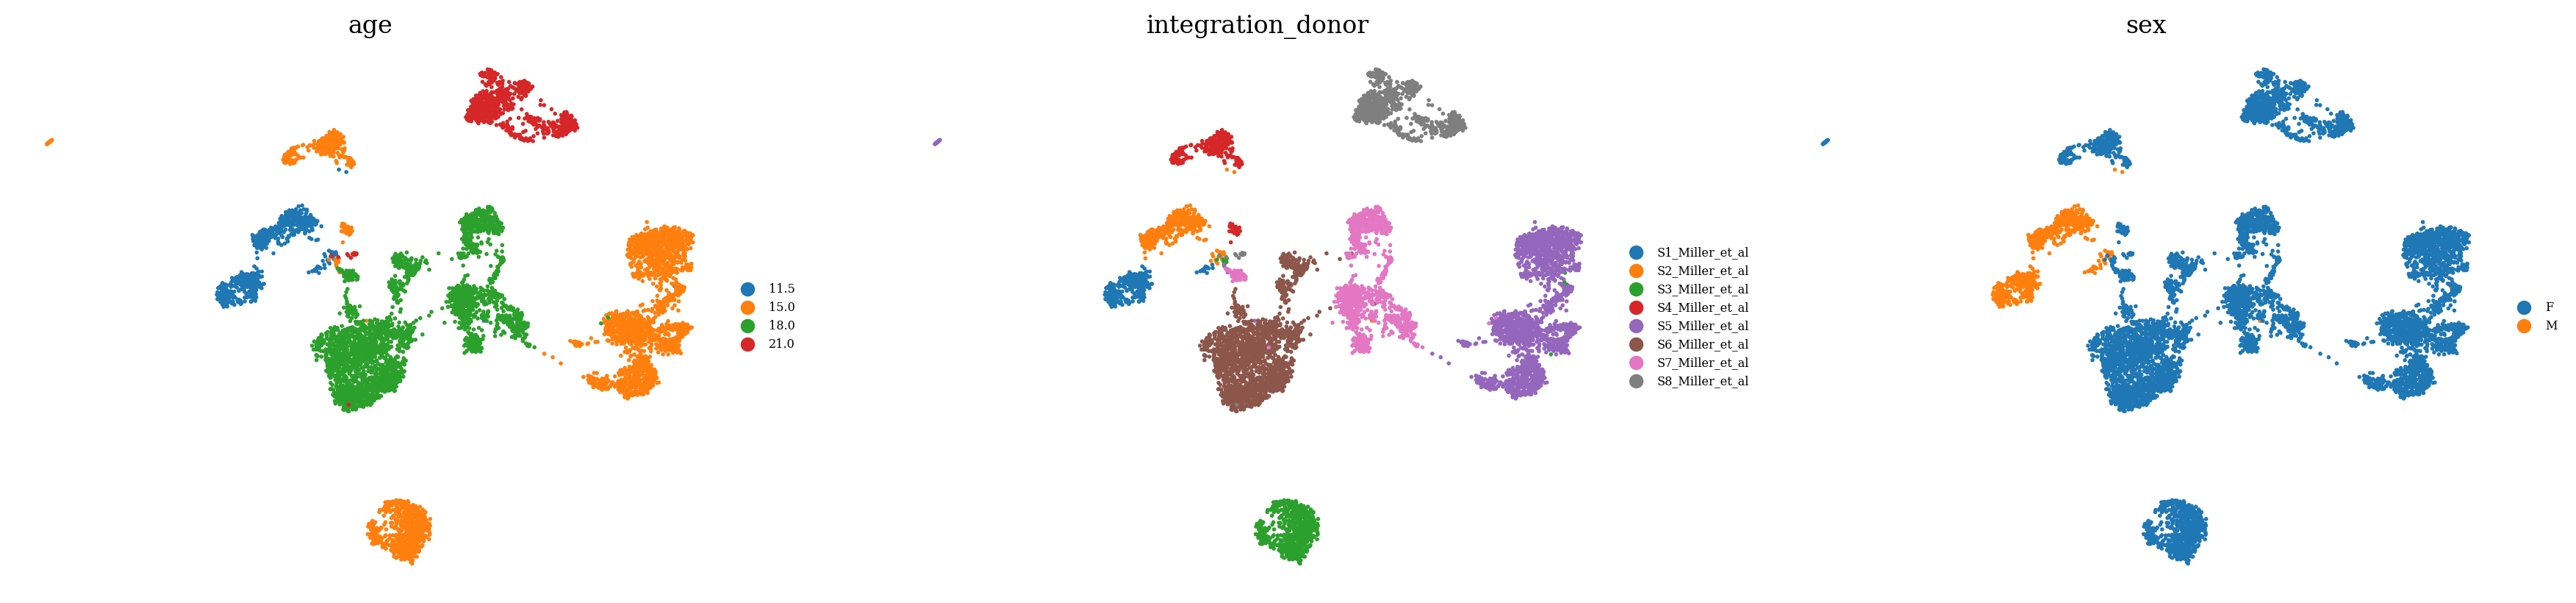

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

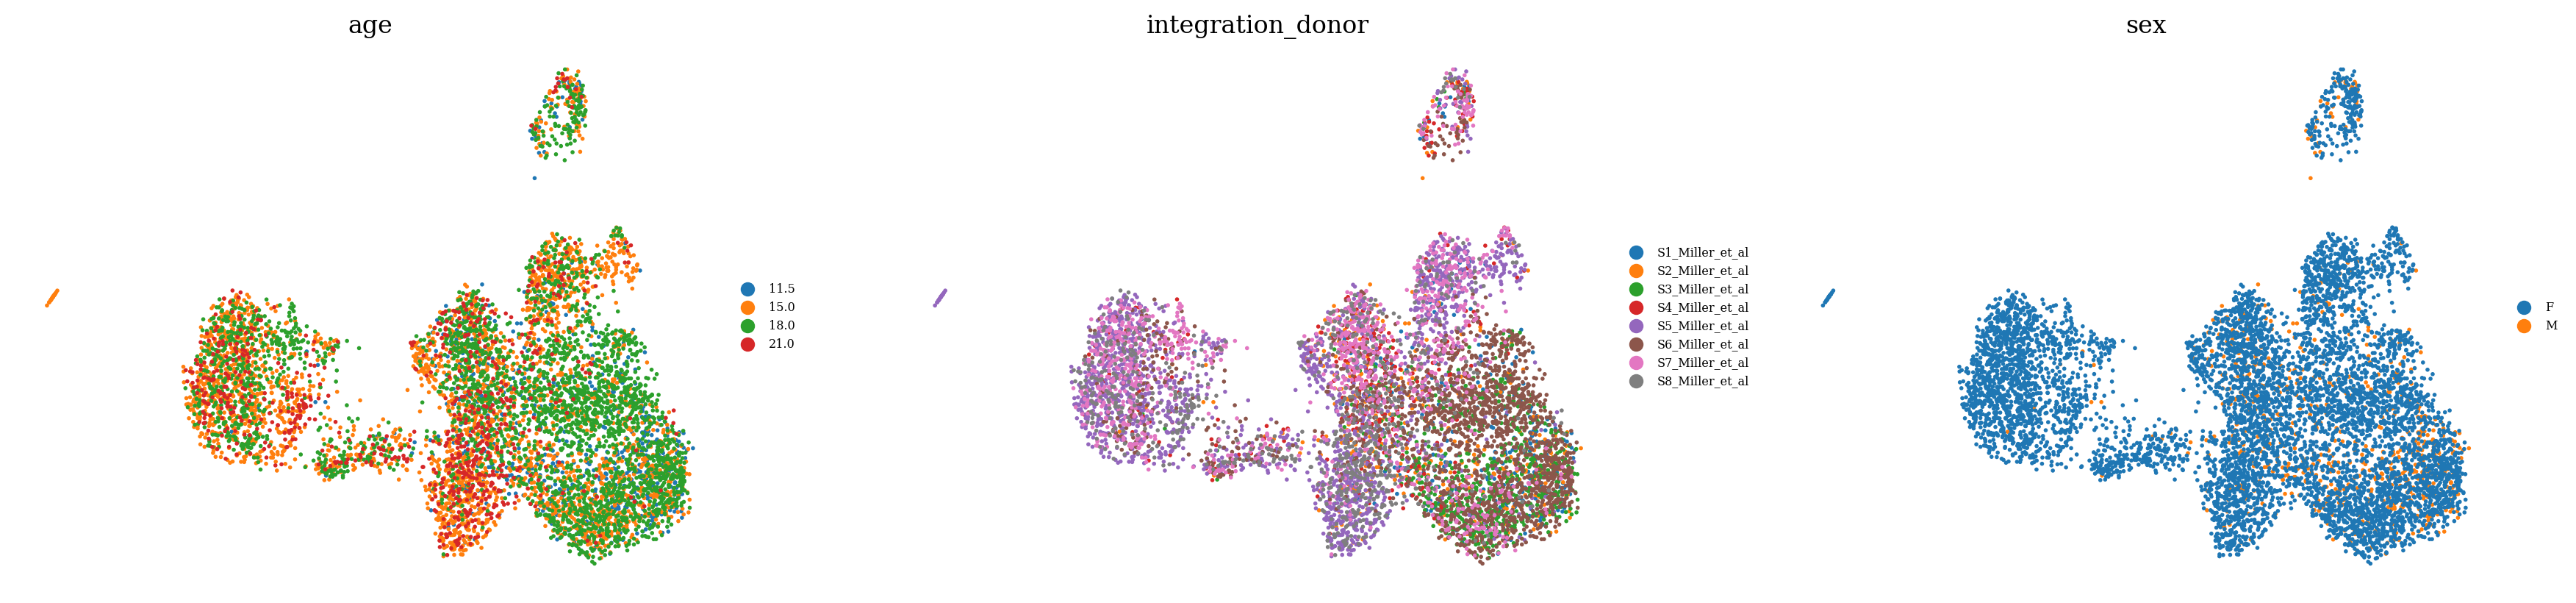

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<01:23,  2.75it/s]

  2%|▏         | 4/232 [00:00<00:38,  5.86it/s]

 10%|▉         | 23/232 [00:00<00:05, 39.71it/s]

 16%|█▌        | 37/232 [00:00<00:03, 60.15it/s]

 21%|██        | 49/232 [00:01<00:02, 73.64it/s]

 26%|██▋       | 61/232 [00:01<00:02, 84.78it/s]

 31%|███▏      | 73/232 [00:01<00:01, 93.63it/s]

 37%|███▋      | 85/232 [00:01<00:01, 100.45it/s]

 42%|████▏     | 97/232 [00:01<00:01, 105.53it/s]

 47%|████▋     | 109/232 [00:01<00:01, 109.34it/s]

 52%|█████▏    | 121/232 [00:01<00:00, 112.25it/s]

 57%|█████▋    | 133/232 [00:01<00:00, 114.24it/s]

 62%|██████▎   | 145/232 [00:01<00:00, 115.41it/s]

 68%|██████▊   | 157/232 [00:01<00:00, 116.32it/s]

 73%|███████▎  | 169/232 [00:02<00:00, 116.98it/s]

 78%|███████▊  | 181/232 [00:02<00:00, 114.65it/s]

 83%|████████▎ | 193/232 [00:02<00:00, 115.82it/s]

 88%|████████▊ | 205/232 [00:02<00:00, 116.34it/s]

 94%|█████████▎| 217/232 [00:02<00:00, 116.11it/s]

 99%|█████████▊| 229/232 [00:02<00:00, 116.52it/s]

100%|██████████| 232/232 [00:02<00:00, 89.23it/s] 

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.5721303054112459

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)